# Fintech

In [ ]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

**Sosyal Medya Finansal Yorum ve Haber Analizi ile Piyasa Hareketlerinin Tahmini Projesi**


---



Bu projede, sosyal medyadaki finansal yorumlar ve haberleri analiz ederek hisse senetlerinin piyasa hareketlerini tahmin etmek amaçlanmaktadır. Proje, i*ki temel problem* üzerine yapılandırılmıştır:

1. **Sosyal Medya Finansal Yorumlarının Duygusal Analizi**
  <br>Projenin ilk aşamasında, sosyal medyada bir hisse senediyle ilgili yapılan finansal yorumların duygusal analizini gerçekleştireceğiz. Bu aşama, ilgili hisse senedi hakkında pozitif, negatif veya nötr yorumları tespit etmeyi ve bunları bir duygu puanı ile ifade etmeyi hedeflemektedir. Bu analiz, hisse senediyle ilgili genel piyasa algısını anlamak için bir temel oluşturacaktır.

2. **Piyasa Hareketlerinin Tahmini**
  <br>İkinci aşamada, elde edilen duygu analizi puanları ile hisse senedi piyasasındaki hareketleri birleştirerek hisse kapanış değerlerini tahmin etmeye çalışacağız. Bu adım, duygusal analiz sonuçlarının hisse değerleri üzerindeki etkisini anlamaya ve bu etkiden yararlanarak gelecekteki piyasa hareketlerini öngörmeye odaklanacaktır.


## Stoklar Hakkındaki Tweetler Üzerinden Duygu Analizi Skorlama

Bu problemde amaç, sosyal medya platformlarında, özellikle Twitter üzerinde, belirli hisse senetleriyle ilgili atılan tweetlerin duygusal analizini yaparak her bir tweet için bir **duygu skoru** hesaplamaktır. Bu skor, tweetlerin hisse senedi hakkında **pozitif**, **negatif** veya **nötr** bir algı oluşturup oluşturmadığını değerlendirmek için kullanılacaktır.

Skorlama:

* Pozitif tweetler için pozitif yüksek skor,
* Negatif tweetler için negatif düşük skor,
* Nötr tweetler için 0'a yakın bir skor verilerek hisse senedi hakkında genel piyasa algısı oluşturulacaktır.


### Problem Tanımı

### Veri Toplama

**Dataset Açıklaması**

Bu çalışma kapsamında internetten hazır olarak bulunmuş bir Stock Dataseti kullanılmıştır. Dataset, hisse senetleri ve şirketlerle ilgili tweetlerden oluşmaktadır ve GitHub üzerinde depolanmıştır. Veriler, githuba'a yüklenmiş github raw formatında read_csv yöntemi kullanılarak okunmuştur.

**Dataset Sütunları**:
* Date: Tweet'in atıldığı tarih ve saat bilgisini barındırır.
* Tweet: Tweet'in içerik kısmını, yani kullanıcıların yazdığı metni içerir.
* Stock Name: Tweet'in hangi hisse senedi ile ilgili olduğunu belirtir.
* Company Name: Tweet'in hangi şirket ile ilgili olduğunu belirtir.

**Veri Kaynağı**

Bu dataset hazır bir veri kümesidir ve ikincil veri toplama yöntemiyle elde edilmiştir. Bu, başkaları tarafından toplanmış mevcut verilerin kullanılması işlemidir. Dolayısıyla, veriler önceden işlenmiş olup, projede doğrudan analiz için kullanılmıştır.

In [ ]:
stock_name = 'TSLA'

# Define the URL of the raw CSV file on GitHub
url = "https://raw.githubusercontent.com/AysenurYrr/ML-Lab/refs/heads/main/Stock%20Tweets%20for%20Sentiment%20Analysis%20and%20Prediction/stock_tweets.csv"

all_tweets = pd.read_csv(url)

print(all_tweets.shape)
all_tweets.head()

(80793, 4)


Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.

In [ ]:
df = all_tweets[all_tweets['Stock Name'] == stock_name]
print(df.shape)
df.head()

(37422, 4)


Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.

### Metin Ön işleme

Gerekli ek sütunlar eklenmiştir.

In [ ]:
sent_df = df.copy()
sent_df["sentiment_score"] = ''
sent_df["Negative"] = ''
sent_df["Neutral"] = ''
sent_df["Positive"] = ''
sent_df.head()

Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  \
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.   
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.   
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.   
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.   
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.   

  sentiment_score Negative Neutral Positive  
0                                            
1                                            
2                                            
3                                            
4

In [ ]:
!pip install nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import unicodedata

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Metin ön işleme fonksiyonu
def preprocess_text(text):
    try:
        # Unicode normalizasyonu
        text = unicodedata.normalize('NFKD', text)
        # Küçük harfe dönüştürme
        text = text.lower()
        # Noktalama işaretlerini temizleme
        text = re.sub(r'[^\w\s]', '', text)
        # Sayıları kaldırma
        text = re.sub(r'\d+', '', text)
        # Lemmatizasyon
        words = text.split()
        text = " ".join([lemmatizer.lemmatize(word) for word in words])
        # Stopwords kaldırma
        words = [word for word in words if word not in stop_words]
        # Tek harfli kelimeleri kaldırma
        words = [word for word in words if len(word) > 1]
        # Temizlenmiş metni birleştirme
        text = " ".join(words)
        return text
    except TypeError:
        return ""

# Tweet sütununu temizle ve yeni bir sütuna kaydet
sent_df['Cleaned_Tweet'] = sent_df['Tweet'].apply(preprocess_text)
sent_df

Date  \
0      2022-09-29 23:41:16+00:00   
1      2022-09-29 23:24:43+00:00   
2      2022-09-29 23:18:08+00:00   
3      2022-09-29 22:40:07+00:00   
4      2022-09-29 22:27:05+00:00   
...                          ...   
37417  2021-09-30 02:52:38+00:00   
37418  2021-09-30 02:40:26+00:00   
37419  2021-09-30 01:59:02+00:00   
37420  2021-09-30 01:38:26+00:00   
37421  2021-09-30 01:16:13+00:00   

                                                   Tweet Stock Name  \
0      Mainstream media has done an amazing job at br...       TSLA   
1      Tesla delivery estimates are at around 364k fr...       TSLA   
2      3/ Even if I include 63.0M unvested RSUs as of...       TSLA   
3      @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA   
4      @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA   
...                                                  ...        ...   
37417  Playing in the dirt and #chasingsunsets\n@tesl...       TSLA   
37418  I agree with @freshjiva that $TSLA ‘s EV busin...       TSLA   
37419                             Hold. On. Tight. $TSLA       TSLA   
37420  Get ready for a $TSLA _ _ _ _ _ _  Q3 delivery...       TSLA   
37421  In other words, AMD has been giving Tesla pref...       TSLA   

      Company Name sentiment_score Negative Neutral Positive  \
0      Tesla, Inc.                                             
1      Tesla, Inc.                                             
2      Tesla, Inc.                                             
3      Tesla, Inc.                                             
4      Tesla, Inc.                                             
...            ...             ...      ...     ...      ...   
37417  Tesla, Inc.                                             
37418  Tesla, Inc.                                             
37419  Tesla, Inc.                                             
37420  Tesla, Inc.                                             
37421  Tesla, Inc.                                             

                                           Cleaned_Tweet  
0      mainstream media done amazing job brainwashing...  
1          tesla delivery estimates around analysts tsla  
2      even include unvested rsus additional equity n...  
3      realdanodowd wholemarsblog tesla hahaha still ...  
4      realdanodowd tesla stop trying kill kids sad d...  
...                                                  ...  
37417  playing dirt chasingsunsets tesla elonmusk tes...  
37418  agree freshjiva tsla ev business alone worth g...  
37419                                    hold tight tsla  
37420           get ready tsla delivery number ur answer  
37421  words amd giving tesla preferential treatment ...  

[37422 rows x 9 columns]

### EDA

#### Kelime Frekansı

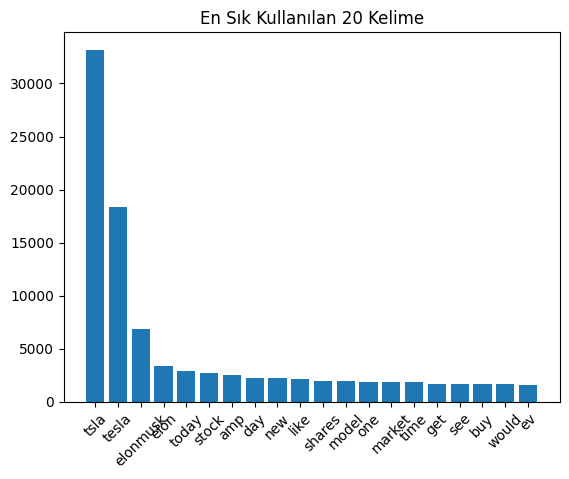

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Kelime frekansı
all_words = " ".join(sent_df['Cleaned_Tweet']).split()
word_freq = Counter(all_words).most_common(20)

# Görselleştirme
words, counts = zip(*word_freq)
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("En Sık Kullanılan 20 Kelime")
plt.show()


#### Kelime Bulutu

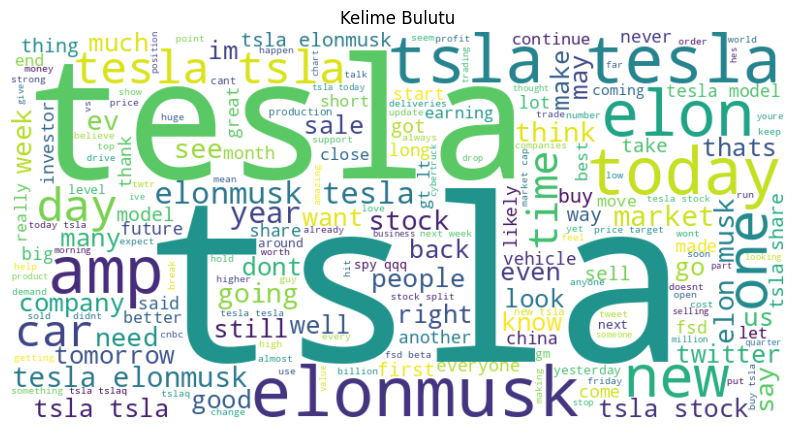

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(all_words))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Kelime Bulutu")
plt.show()


### Sentiment Analizi

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

sentiment_analyzer = SentimentIntensityAnalyzer()

# Sentiment analiz fonksiyonu
def analyze_sentiment(text):
    sentiment = sentiment_analyzer.polarity_scores(text)
    return sentiment['compound'], sentiment['neg'], sentiment['neu'], sentiment['pos']

# Sentiment analizi sonuçlarını yeni sütunlara ekle
sent_df[['sentiment_score', 'Negative', 'Neutral', 'Positive']] = sent_df['Cleaned_Tweet'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)

# Sonuçların ilk birkaç satırını görüntüleme
sent_df.head()


Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  \
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.   
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.   
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.   
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.   
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.   

   sentiment_score  Negative  Neutral  Positive  \
0           0.0772     0.196    0.627     0.177   
1           0.0000     0.000    1.000     0.000   
2           0.2960     0.000    0.905     0.095   
3          -0.7096     0.319    0.514     0.167   
4          -0.8750     0.588    0.412     0.000   

                                       Cleaned_Tweet  
0  mainstream media done amazing job brainwashing...  
1      tesla delivery estimates around analysts tsla  
2  even include unvested rsus additional equity n...  
3  realdanodowd wholemarsblog tesla hahaha still ...  
4  realdanodowd tesla stop trying kill kids sad d...

### Değerlendirme

Elimizdeki verilerde *sentiment_score* değerleri etiketlenmemişti. Bu durum, verinin ikinci el bir kaynak tarafından toplanmış olması nedeniyle normal bir durumdur, çünkü çoğu zaman veri istediğimiz gibi hazırlanmış olmayabilir. Bu nedenle, *sentiment_score*'ların doğruluğunu basit ve sezgisel bir şekilde incelenmiştir.

**Bu inceleme sırasında**

* Cleaned_Tweet ve *sentiment_score* değerlerini yan yana değerlendirerek analiz yapılmıştır.

* Örneğin, "kill", "sad", "angry", "bad" gibi negatif anlam taşıyan kelimeler için düşük sentiment skoru beklenirken, olumlu içerikli kelimeler (ör. "amazing", "great", "love") için yüksek sentiment skorlarının atanmış olması beklenmiştir.
Bu yöntem, skorların genel doğruluğunu anlamak için yeterli bir yaklaşım sundu. Ancak daha detaylı bir analiz için etiketlenmiş bir veri seti veya farklı bir model doğrulama yöntemi kullanılabilir.

In [ ]:
sent_df['Date'] = pd.to_datetime(sent_df['Date'])
sent_df['Date'] = sent_df['Date'].dt.date
sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Stock Name', 'Company Name','Tweet'])
sent_df.head()

Date  sentiment_score  \
0  2022-09-29           0.0772   
1  2022-09-29           0.0000   
2  2022-09-29           0.2960   
3  2022-09-29          -0.7096   
4  2022-09-29          -0.8750   

                                       Cleaned_Tweet  
0  mainstream media done amazing job brainwashing...  
1      tesla delivery estimates around analysts tsla  
2  even include unvested rsus additional equity n...  
3  realdanodowd wholemarsblog tesla hahaha still ...  
4  realdanodowd tesla stop trying kill kids sad d...

In [ ]:
sent_df_cleaned = sent_df.drop(columns=['Cleaned_Tweet'])

### Sonuç

Bir gün içerisinde farklı saatlerde birden fazla tweet atılabilir. Ancak bizim amacımız, hissenin ilgili gün sonunda kaç ile kapanacağını tahmin etmektir. Bu hedef doğrultusunda, elimizde bulunan veri setleri hisse senetlerinin saatlik değil, günlük değerlerini içerdiği için günlük analiz yapmamız gerekmektedir.

Bu nedenle, belirli bir gün içerisinde atılan tüm tweetlerin ortalamasını alarak analizlerimizi basitleştiriyoruz. Bu işlem için, Python'da groupby fonksiyonunu kullanarak tweetleri tarih (Date) sütununa göre gruplandırıyoruz. Böylece her bir grup için ilgili metriklerin ortalamasını hesaplayabiliyoruz. Bu yöntem, gün bazında daha doğru bir analiz yapmamızı sağlıyor.



In [ ]:
twitter_df = sent_df_cleaned.groupby([sent_df_cleaned['Date']]).mean()
print(twitter_df.shape)
twitter_df.head()


(365, 1)


sentiment_score
Date                       
2021-09-30         0.268967
2021-10-01         0.219463
2021-10-02         0.264478
2021-10-03         0.255598
2021-10-04         0.107341

Sentiment skorlarıyla ilgili yapılan değerlendirme sonucunda, bu skorların uygun ve mantıklı olduğu görüldüğü için işlemlere devam edilmiştir. İlk bölümde sentiment skorları başarıyla elde edilmiştir. Şimdi, bu sentiment skorlarını hisse senedi performansıyla karşılaştırılacaktır.

Eğer elimizde etiketli veriler olsaydı, daha başarılı ve net bir karşılaştırmalı sonuç bölümü hazırlanabilirdi. Ancak, bu veriye erişimimiz olmadığından dolayı gerçek sonuç bölümümüz, hisse senedi tahmini aşamasında ortaya çıkacaktır. Burada, sentiment skorlarının doğru bir şekilde analiz edilmesi, hisse senedi tahmini sonuçlarımızı doğrudan etkileyecek ve bu nedenle oldukça kritik bir öneme sahiptir.

## Hisse Senedi Kapanış Değeri Tahmini



### Problem Tanımı

Bu aşamada amaç, hisse senedi kapanış değerlerini tahmin etmek için sosyal medyadan elde edilen duygu analizi skorlarını ve ilgili hisse senedine ait piyasa verilerini birleştirerek bir tahmin modeli geliştirmektir.

**Girdi Verileri (Featurelarımız)**:
* Duygu Analizi Skorları: İlk aşamada sosyal medyadan elde edilen pozitif, negatif ve nötr duygu skorları.
* Piyasa Verileri: Hisse senedine ait tarihsel piyasa verileri (açılış fiyatı, en yüksek fiyat, en düşük fiyat, işlem hacmi vb.).


### Veri Toplama

**Hisse Senedi Fiyat Verileri:**
<br>Hisse senetleriyle ilgili tarihsel fiyat verileri aşağıdaki sütunlardan oluşmaktadır:

* Date: Tarih bilgisi.
* Open: Hisse senedinin işlem günündeki açılış fiyatı.
* High: Gün içindeki en yüksek fiyat.
* Low: Gün içindeki en düşük fiyat.
* Close: Gün sonu kapanış fiyatı.
* Adj Close: Düzeltilmiş kapanış fiyatı (temettü ve bölünme gibi ayarlamaları içerir).
* Volume: Gün boyunca işlem gören toplam hisse miktarı.
* Stock Name: İlgili hisse senedinin adı (ör. TSLA, TSM, vb.).

Bu Sentiment veri seti ve Hisse senedi veriseti birleştirilerek, sosyal medyadan gelen duygu puanları ile hisse senedi fiyatları arasındaki ilişkiyi incelemek ve hisse senedi kapanış değerlerini tahmin eden bir model geliştirmek hedeflenmiştir.

In [ ]:
all_stocks = pd.read_csv('https://raw.githubusercontent.com/AysenurYrr/ML-Lab/refs/heads/main/Stock%20Tweets%20for%20Sentiment%20Analysis%20and%20Prediction/stock_yfinance_data.csv')
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


Date        Open        High         Low       Close   Adj Close  \
0  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1  2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2  2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3  2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4  2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

     Volume Stock Name  
0  53868000       TSLA  
1  51094200       TSLA  
2  91449900       TSLA  
3  55297800       TSLA  
4  43898400       TSLA

### Veri Ön İşleme

#### Veri Birleştirme

In [ ]:
stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [ ]:
final_df = stock_df.join(twitter_df, how="left", on="Date")
final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)

(252, 8)


In [ ]:
final_df.head()

Date        Open        High         Low       Close   Adj Close  \
0  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1  2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2  2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3  2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4  2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

     Volume  sentiment_score  
0  53868000         0.268967  
1  51094200         0.219463  
2  91449900         0.107341  
3  55297800         0.109434  
4  43898400         0.212151

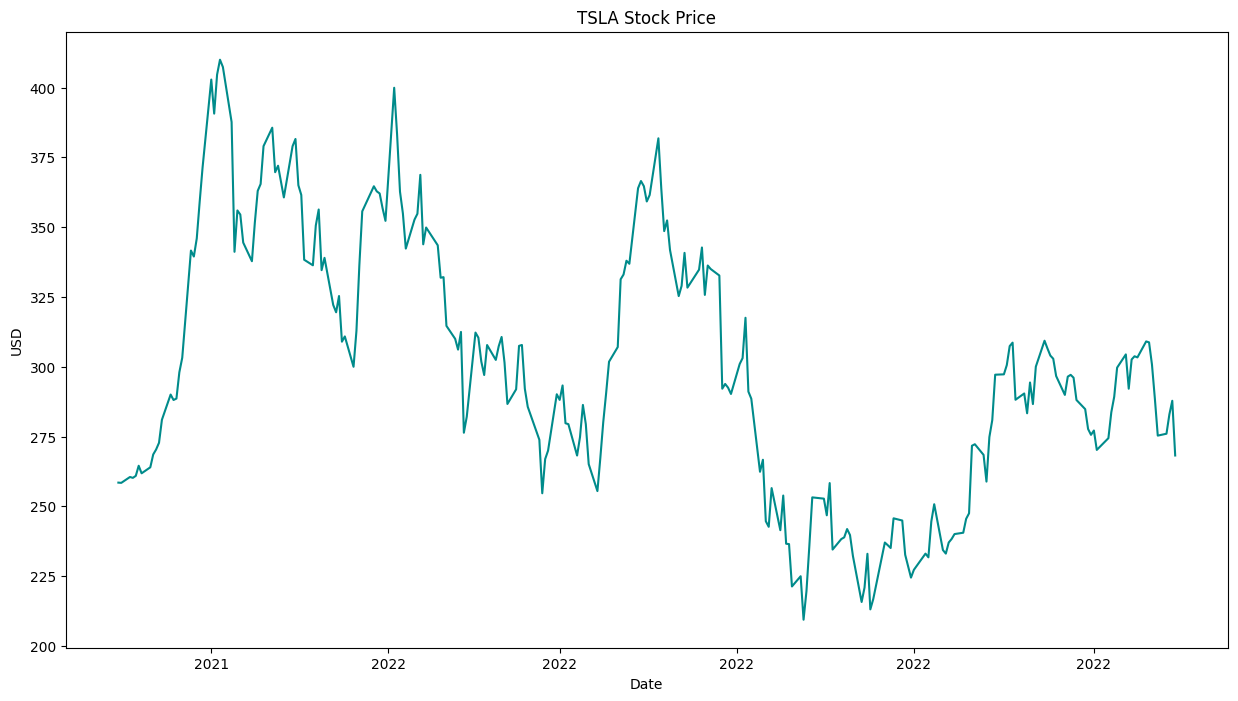

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

#### Feature Engineering

1. 7 Günlük ve 20 Günlük Hareketli Ortalama (MA7 ve MA20)
<br>MA7: Son 7 gündeki kapanış fiyatlarının ortalamasını alır.
<br>MA20: Son 20 gündeki kapanış fiyatlarının ortalamasını alır.
<br>Amaç: Kısa ve uzun vadeli trendleri analiz etmek. Örneğin, kısa vadeli hareketli ortalamanın uzun vadeli ortalamanın üstüne çıkması genellikle bir yükseliş sinyali olarak kabul edilir.

2. MACD (Moving Average Convergence Divergence)
<br>MACD, iki üstel hareketli ortalama (EMA) arasındaki farkı hesaplar:
26 günlük EMA (uzun vadeli) ve 12 günlük EMA (kısa vadeli) kullanılır.
<br>Kapanış fiyatı (Pclose) ile açılış fiyatı (Popen) arasındaki farktır.
<br>Amaç: Piyasa momentumu hakkında bilgi verir. Örneğin, MACD'nin sıfırın üstünde olması genellikle yükseliş trendini gösterir.

3. Bollinger Bantları
<br>Orta Bant (middle line): MA20.
<br>Üst Bant (upper_band): MA20 + 2 x 20 günlük standart sapma.
<br>Alt Bant (lower_band): MA20 - 2 x 20 günlük standart sapma.
<br>Amaç: Hisse fiyatının volatilitesini ölçmek ve aşırı alım/aşırı satım seviyelerini tespit etmek. Fiyat üst banda yaklaşırsa, aşırı alım durumu olabilir; alt banda yaklaşırsa, aşırı satım durumu olabilir.

4. Üstel Hareketli Ortalama (EMA)
<br>EMA, fiyatlara daha fazla ağırlık vererek, son fiyatların etkisini artırır.
<br>Amaç: Trendleri daha hızlı algılamak ve piyasa hareketlerini yakalamak.

5. LogMomentum
<br>LogMomentum: Fiyatların logaritmik değişimini ölçer.
<br>Amaç: Piyasa momentumunu analiz etmek ve fiyatların değişim hızını anlamak.



In [ ]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [ ]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

Date        Open        High         Low       Close   Adj Close  \
0  2021-10-28  356.103333  360.333344  351.399994  359.013336  359.013336   
1  2021-10-29  360.619995  371.736664  357.736664  371.333344  371.333344   
2  2021-11-01  381.666656  403.250000  372.886658  402.863342  402.863342   
3  2021-11-02  386.453339  402.863342  382.000000  390.666656  390.666656   
4  2021-11-03  392.443329  405.130005  384.206665  404.619995  404.619995   

      Volume  sentiment_score         MA7        MA20       MACD       20SD  \
0   81639600         0.177246  325.127141  288.855501  -9.269895  32.580099   
1   89755200         0.134125  336.946189  294.501834 -10.609662  36.566908   
2  168146100         0.208266  351.926666  301.619501 -11.860446  42.906989   
3  128213400         0.176500  364.418095  308.143001 -14.295169  46.078655   
4  103885500         0.197605  373.418095  315.328168 -15.716662  49.410503   

   upper_band  lower_band         EMA  logmomentum  
0  354.015698  223.695304  353.510805     5.880570  
1  367.635649  221.368019  365.392497     5.914404  
2  387.433479  215.805523  390.373061     5.996112  
3  400.300312  215.985690  390.568791     5.965292  
4  414.149173  216.507162  399.936260     6.000474

#### Veri Azaltma

Veri azaltma işlemi, veri setinin boyutu, hesaplama maliyeti ve gereksiz bilgi içerip içermediğine bağlı olarak yapılması gereken bir adımdır. Ancak mevcut durumdaki veri seti, zaman serisi verilerinden oluşmaktadır ve her bir örnek kritik bir öneme sahiptir. Bu nedenle satır düzeyinde yapılacak bir silme işleminin analiz sonuçlarını olumsuz etkileyeceği düşünülmüştür.

Daha önce, group_by date mean() işlemi uygulayarak veriler zaten oldukça uygun bir forma getirilmişti. Bu nedenle, veri setindeki satırların tamamının korunması tercih edilmiştir. Benzer şekilde, veri setindeki her bir sütunun değerli bilgiler içerebileceği ihtimali göz önünde bulundurularak, sütunlardan herhangi birinin çıkarılmasının da gerekli olmadığı düşünülmüştür.

Ayrıca, veri seti küçük boyutlu olduğundan, herhangi bir hesaplama maliyeti veya bellek problemi oluşturması beklenmiyor. Bu nedenle, mevcut veri setinin olduğu gibi kullanılmıştır.

In [ ]:
dataset.shape

(232, 16)

#### Veri Ölçeklendirme

Örneğin, veri setinizdeki Volume ve sentiment_score gibi sütunların büyük farklılıklar içermesi, modelin bir sütuna daha fazla ağırlık vermesine neden olabilir. Ölçeklendirme, tüm sütunların eşit derecede temsil edilmesini sağlayacaktır

In [ ]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from pickle import dump

Aşağıdaki kod, veri setinde tarih verilerini işlemek ve eksik verileri doldurmak için yapılan bir dizi işlemi içerir. Kodun amacı, veri setini datetime (zaman serisi) formatında düzenlemek, eksik verileri doldurmak ve daha sonraki işlemler için uygun bir hale getirmektir.

ffill(): Eksik verileri (NaN) bir önceki geçerli değerle doldurur

In [ ]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

Veri analizi ve modelleme süreçlerinde, özelliklerin farklı ölçeklerde olması, makine öğrenmesi algoritmalarının performansını olumsuz etkileyebilir. Özellikle zaman serisi ve finansal veriler gibi farklı büyüklüklerde değerlere sahip veri setlerinde, ölçeklendirme teknikleri kullanmak önemlidir. Bu projede aşağıdaki dört farklı ölçeklendirme yöntemi uygulanmıştır


**Robust Ölçeklendirme (RobustScaler):**
<br>**Amaç:** Medyan ve interquartile range (IQR) kullanarak ölçeklendirme yapar. Bu yöntem, aykırı değerlere (outliers) karşı dayanıklıdır.
<br>**Kullanım Durumu:** Aykırı değerlerin bulunduğu veri setlerinde kullanılır, çünkü bu değerlerin ölçeklendirme işlemi üzerindeki etkisini azaltır.

In [ ]:
dataset

Open        High         Low       Close   Adj Close  \
2021-10-28  356.103333  360.333344  351.399994  359.013336  359.013336   
2021-10-29  360.619995  371.736664  357.736664  371.333344  371.333344   
2021-11-01  381.666656  403.250000  372.886658  402.863342  402.863342   
2021-11-02  386.453339  402.863342  382.000000  390.666656  390.666656   
2021-11-03  392.443329  405.130005  384.206665  404.619995  404.619995   
...                ...         ...         ...         ...         ...   
2022-09-23  283.089996  284.500000  272.820007  275.329987  275.329987   
2022-09-26  271.829987  284.089996  270.309998  276.010010  276.010010   
2022-09-27  283.839996  288.670013  277.510010  282.940002  282.940002   
2022-09-28  283.079987  289.000000  277.570007  287.809998  287.809998   
2022-09-29  282.760010  283.649994  265.779999  268.209991  268.209991   

               Volume  sentiment_score         MA7        MA20       MACD  \
2021-10-28   81639600         0.177246  325.127141  288.855501  -9.269895   
2021-10-29   89755200         0.134125  336.946189  294.501834 -10.609662   
2021-11-01  168146100         0.208266  351.926666  301.619501 -11.860446   
2021-11-02  128213400         0.176500  364.418095  308.143001 -14.295169   
2021-11-03  103885500         0.197605  373.418095  315.328168 -15.716662   
...               ...              ...         ...         ...        ...   
2022-09-23   63748400         0.150472  298.517142  290.471501  -3.645233   
2022-09-26   58076900         0.145204  294.554286  289.867502  -1.179826   
2022-09-27   61925200         0.171761  291.638572  289.773502  -0.521519   
2022-09-28   54664800         0.144716  288.601427  290.279001   0.467601   
2022-09-29   77620600         0.085613  282.812853  289.909001  -0.111499   

                 20SD  upper_band  lower_band         EMA  logmomentum  
2021-10-28  32.580099  354.015698  223.695304  353.510805     5.880570  
2021-10-29  36.566908  367.635649  221.368019  365.392497     5.914404  
2021-11-01  42.906989  387.433479  215.805523  390.373061     5.996112  
2021-11-02  46.078655  400.300312  215.985690  390.568791     5.965292  
2021-11-03  49.410503  414.149173  216.507162  399.936260     6.000474  
...               ...         ...         ...         ...          ...  
2022-09-23  12.782941  316.037384  264.905618  281.379917     5.614332  
2022-09-26  13.180598  316.228698  263.506306  277.799979     5.616807  
2022-09-27  13.225119  316.223739  263.323265  281.226661     5.641694  
2022-09-28  12.929255  316.137511  264.420491  285.615552     5.658820  
2022-09-29  13.465883  316.840768  262.977235  274.011845     5.588035  

[232 rows x 15 columns]

In [ ]:
def robust_normalize_data(df, target_column):
    '''
    df: dataframe object
    target_column: type str -> should reflect the column you want to focus on (e.g., 'Close')

    Returns:
    scaled_df: pandas DataFrame -> scaled dataset including the target_column
    X_scaled_dataset: numpy array -> scaled dataset excluding the target_column
    y_scaled_dataset: numpy array -> scaled target_column data
    '''

    # Initialize RobustScaler for the entire dataset
    scaler = RobustScaler()

    # Fit and transform the entire dataset
    scaled_data = scaler.fit_transform(df)

    # Save the scaler for later use
    dump(scaler, open('robust_scaler.pkl', 'wb'))

    # Convert scaled data back to a DataFrame
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

    # Separate the target column after scaling
    X_scaled_dataset = scaled_df.drop(columns=[target_column]).to_numpy()
    y_scaled_dataset = scaled_df[[target_column]].to_numpy()

    return scaled_df, X_scaled_dataset, y_scaled_dataset

rb_dataset, rb_X_scaled, rb_y_scaled = robust_normalize_data(dataset, "Close")

# Indekslerin korunması için, normalize edilmiş DataFrame'in indekslerini eski indekslerle değiştiriyoruz
rb_dataset.index = dataset.index

rb_dataset.head()

Open      High       Low     Close  Adj Close    Volume  \
2021-10-28  0.865276  0.773667  0.856082  0.852008   0.852008  0.085960   
2021-10-29  0.934992  0.937044  0.946877  1.029368   1.029368  0.366330   
2021-11-01  1.259853  1.388541  1.163954  1.483276   1.483276  3.074505   
2021-11-02  1.333736  1.383001  1.294535  1.307692   1.307692  1.694948   
2021-11-03  1.426194  1.415476  1.326153  1.508565   1.508565  0.854490   

            sentiment_score       MA7      MA20      MACD      20SD  \
2021-10-28         0.102961  0.410961 -0.115984 -0.513614  1.026454   
2021-10-29        -0.478606  0.595294 -0.025052 -0.591597  1.342259   
2021-11-01         0.521330  0.828933  0.089575 -0.664400  1.844474   
2021-11-02         0.092898  1.023753  0.194634 -0.806115  2.095709   
2021-11-03         0.377545  1.164119  0.310349 -0.888854  2.359633   

            upper_band  lower_band       EMA  logmomentum  
2021-10-28    0.256073   -0.590628  0.790683     0.782404  
2021-10-29    0.430816   -0.624763  0.961228     0.928901  
2021-11-01    0.684819   -0.706351  1.319787     1.282696  
2021-11-02    0.849899   -0.703708  1.322597     1.149244  
2021-11-03    1.027578   -0.696059  1.457053     1.301582

**Z-Score Standardizasyonu (Standardization):**
<br>**Amaç:** Verilerin ortalamasını sıfır, standart sapmasını ise 1 yaparak ölçeklendirme işlemi gerçekleştirir. Bu yöntem, özellikle normal dağılıma yakın verilere uygundur.
<br>**Kullanım Durumu:** Verilerin pozitif ve negatif değerler alabilmesi gerektiğinde veya modelin, veri setindeki farklı ölçeklerden etkilenmesini istemediğimizde kullanılır.

In [ ]:
def standard_normalize_data(df, target_column):
    '''
    df: dataframe object
    target_column: type str -> should reflect the column you want to focus on (e.g., 'Close')

    Returns:
    scaled_df: pandas DataFrame -> scaled dataset including the target_column
    X_scaled_dataset: numpy array -> scaled dataset excluding the target_column
    y_scaled_dataset: numpy array -> scaled target_column data
    '''

    # Initialize StandardScaler for the entire dataset
    scaler = StandardScaler()

    # Fit and transform the entire dataset
    scaled_data = scaler.fit_transform(df)

    # Save the scaler for later use
    dump(scaler, open('standard_scaler.pkl', 'wb'))

    # Convert scaled data back to a DataFrame
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

    # Separate the target column after scaling
    X_scaled_dataset = scaled_df.drop(columns=[target_column]).to_numpy()
    y_scaled_dataset = scaled_df[[target_column]].to_numpy()

    return scaled_df, X_scaled_dataset, y_scaled_dataset

std_dataset, std_X_scaled, std_y_scaled = standard_normalize_data(dataset, "Close")

# Indekslerin korunması için, normalize edilmiş DataFrame'in indekslerini eski indekslerle değiştiriyoruz
std_dataset.index = dataset.index

std_dataset.head()

Open      High       Low     Close  Adj Close    Volume  \
2021-10-28  1.151337  1.075447  1.268033  1.237484   1.237484  0.019099   
2021-10-29  1.247284  1.315871  1.406546  1.501407   1.501407  0.368278   
2021-11-01  1.694375  1.980290  1.737710  2.176854   2.176854  3.741099   
2021-11-02  1.796058  1.972138  1.936919  1.915572   1.915572  2.022968   
2021-11-03  1.923302  2.019927  1.985154  2.214486   2.214486  0.976244   

            sentiment_score       MA7      MA20      MACD      20SD  \
2021-10-28         0.192836  0.517310 -0.310012 -0.880576  1.200254   
2021-10-29        -0.567176  0.780726 -0.172931 -1.009446  1.612182   
2021-11-01         0.739575  1.114603 -0.000130 -1.129756  2.267256   
2021-11-02         0.179686  1.393005  0.158247 -1.363948  2.594961   
2021-11-03         0.551672  1.593593  0.332687 -1.500678  2.939217   

            upper_band  lower_band       EMA  logmomentum  
2021-10-28    0.200092   -0.959520  1.130911     1.197109  
2021-10-29    0.460539   -1.021546  1.388743     1.412309  
2021-11-01    0.839121   -1.169795  1.930820     1.932024  
2021-11-02    1.085166   -1.164993  1.935068     1.735988  
2021-11-03    1.349989   -1.151095  2.138341     1.959768

**Min-Max Ölçeklendirme (Normalization):**
<br>**Amaç:** Verileri belirli bir aralığa (genellikle [0, 1]) indirger. Bu yöntem, veri setinin tüm özelliklerini aynı ölçekte temsil ederek, modelin daha dengeli çalışmasını sağlar.
<br>**Kullanım Durumu:** Özellikle, verilerdeki değerlerin belirli bir aralıkta olması gerektiği durumlarda tercih edilir.

In [ ]:
def minmax_normalize_data(df, target_column):
    '''
    df: dataframe object
    target_column: type str -> should reflect the column you want to focus on (e.g., 'Close')
    feature_range: tuple -> range for MinMaxScaler (default is (0, 1))

    Returns:
    scaled_df: pandas DataFrame -> scaled dataset including the target_column
    X_scaled_dataset: numpy array -> scaled dataset excluding the target_column
    y_scaled_dataset: numpy array -> scaled target_column data
    '''

    # Initialize MinMaxScaler for the entire dataset
    scaler = MinMaxScaler()

    # Fit and transform the entire dataset
    scaled_data = scaler.fit_transform(df)

    # Save the scaler for later use
    dump(scaler, open('minmax_scaler.pkl', 'wb'))

    # Convert scaled data back to a DataFrame
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

    # Separate the target column after scaling
    X_scaled_dataset = scaled_df.drop(columns=[target_column]).to_numpy()
    y_scaled_dataset = scaled_df[[target_column]].to_numpy()

    return scaled_df, X_scaled_dataset, y_scaled_dataset

mm_dataset, mm_X_scaled, mm_y_scaled = minmax_normalize_data(dataset, "Close")

# Indekslerin korunması için, normalize edilmiş DataFrame'in indekslerini eski indekslerle değiştiriyoruz
mm_dataset.index = dataset.index

mm_dataset.head()

Open      High       Low     Close  Adj Close    Volume  \
2021-10-28  0.727955  0.724392  0.727043  0.745958   0.745958  0.327514   
2021-10-29  0.750147  0.782418  0.758916  0.807379   0.807379  0.384555   
2021-11-01  0.853561  0.942772  0.835119  0.964570   0.964570  0.935538   
2021-11-02  0.877080  0.940804  0.880958  0.903764   0.903764  0.654865   
2021-11-03  0.906512  0.952338  0.892058  0.973328   0.973328  0.483872   

            sentiment_score       MA7      MA20      MACD      20SD  \
2021-10-28         0.605517  0.586490  0.405179  0.316999  0.552867   
2021-10-29         0.477702  0.655108  0.445021  0.289365  0.638571   
2021-11-01         0.697464  0.742080  0.495245  0.263567  0.774862   
2021-11-02         0.603305  0.814602  0.541276  0.213348  0.843043   
2021-11-03         0.665864  0.866853  0.591977  0.184028  0.914667   

            upper_band  lower_band       EMA  logmomentum  
2021-10-28    0.543896    0.216796  0.721266     0.802637  
2021-10-29    0.615263    0.199799  0.783047     0.852816  
2021-11-01    0.719001    0.159175  0.912936     0.974001  
2021-11-02    0.786421    0.160491  0.913954     0.928290  
2021-11-03    0.858987    0.164300  0.962661     0.980470

#### Veri Dönüşümü

Mevcut veri setinde kategorik veri bulunmadığı için, dönüşüm gerektiren bir durum söz konusu değildir.

### EDA (Keşifsel Veri Analizi)

#### Univariate Analyse Target için

In [ ]:
#Datasetimizi hatırlayalım
dataset.head()

Open        High         Low       Close   Adj Close  \
2021-10-28  356.103333  360.333344  351.399994  359.013336  359.013336   
2021-10-29  360.619995  371.736664  357.736664  371.333344  371.333344   
2021-11-01  381.666656  403.250000  372.886658  402.863342  402.863342   
2021-11-02  386.453339  402.863342  382.000000  390.666656  390.666656   
2021-11-03  392.443329  405.130005  384.206665  404.619995  404.619995   

               Volume  sentiment_score         MA7        MA20       MACD  \
2021-10-28   81639600         0.177246  325.127141  288.855501  -9.269895   
2021-10-29   89755200         0.134125  336.946189  294.501834 -10.609662   
2021-11-01  168146100         0.208266  351.926666  301.619501 -11.860446   
2021-11-02  128213400         0.176500  364.418095  308.143001 -14.295169   
2021-11-03  103885500         0.197605  373.418095  315.328168 -15.716662   

                 20SD  upper_band  lower_band         EMA  logmomentum  
2021-10-28  32.580099  354.015698  223.695304  353.510805     5.880570  
2021-10-29  36.566908  367.635649  221.368019  365.392497     5.914404  
2021-11-01  42.906989  387.433479  215.805523  390.373061     5.996112  
2021-11-02  46.078655  400.300312  215.985690  390.568791     5.965292  
2021-11-03  49.410503  414.149173  216.507162  399.936260     6.000474

##### Betimsel İnstatistikler

In [ ]:
target = dataset['Close']
print("Betimsel İstatistikler:")
print(target.describe())

Betimsel İstatistikler:
count    232.000000
mean     301.247313
std       46.781154
min      209.386673
25%      268.377487
50%      299.830002
75%      337.840828
max      409.970001
Name: Close, dtype: float64


Ortalama (301.25): Genel fiyat seviyesinin yaklaşık 301 civarında olduğunu göstermektedir.
Standart Sapma (46.78): Fiyatların ortalama çevresinde oldukça değişken olduğunu gösterir.
Minimum ve Maksimum: Fiyatlar 209 ile 410 arasında değişmektedir.
Çeyrekler (25%, 50%, 75%): Verinin çoğunluğunun (ortalama ve medyan çevresindeki) 268 ile 337 arasında toplandığını göstermektedir.

##### Histogram

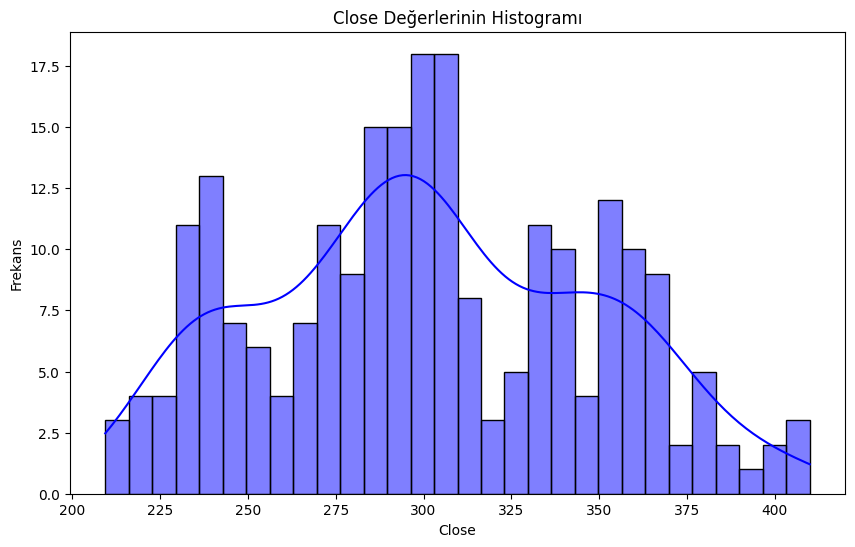

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(target, kde=True, bins=30, color='blue')
plt.title('Close Değerlerinin Histogramı')
plt.xlabel('Close')
plt.ylabel('Frekans')
plt.show()

Çift tepeye (bimodal dağılım) benzer bir yapıya sahiptir. Bu durum, veride iki farklı fiyat seviyesi grubunun olduğunu gösterebilir.
Değerler genellikle 275 ile 325 aralığında yoğunlaşmıştır.
Dağılım, tam anlamıyla simetrik değildir, ancak büyük ölçüde merkezde yoğunlaşan bir yapı sergiler.

##### Box Plot Close

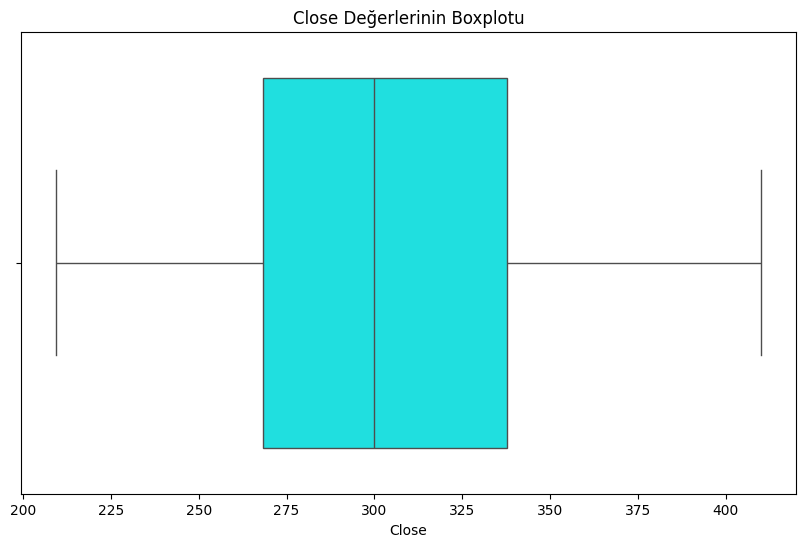

In [ ]:
# 3. Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=target, color='cyan')
plt.title('Close Değerlerinin Boxplotu')
plt.xlabel('Close')
plt.show()

Boxplot, Close değerlerindeki değişkenliği ve olası aykırı değerleri incelememizi sağlar:

Close değerlerinde herhangi bir aykırı değer bulunmamaktadır (grafiğe göre veri tamamen çubukların içinde).
Veri geniş bir aralıkta dağılmış olup, minimum değer 210, maksimum değer ise 410 civarındadır.
Medyan (299.83): Verinin tam ortasındaki değeri temsil eder ve dağılımın büyük ölçüde simetrik olduğunu gösterir.

##### 4. Zaman Serisi Grafiği

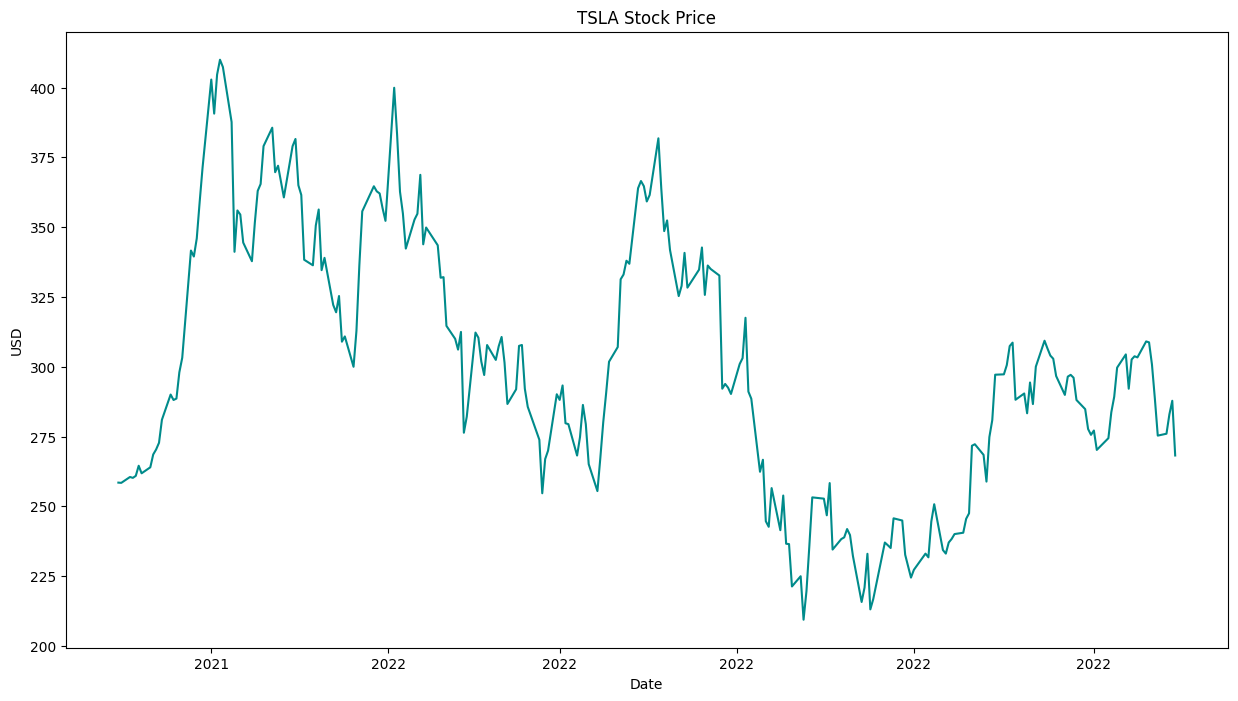

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

Fiyatlarda yüksek dalgalanmalar gözlemlenmiştir. Özellikle belirli dönemlerde ciddi düşüşler ve yükselişler dikkat çekmektedir.
Yaklaşık 2021 Kasım'dan 2022 Ocak'a kadar fiyatlar yükselirken, sonrasında bir düşüş trendi gözlemlenmiştir.
2022 ortalarında fiyatlarda bir toparlanma olmuş, ancak bu durum uzun sürmemiştir.
Grafikte, hem uzun vadeli trendler hem de kısa vadeli dalgalanmalar açıkça görülmektedir.

#### MultiVariate Analyse

##### Korelasyon Matrisi

Değişkenlerin birbirleriyle doğrusal ilişkilerini gösterir.
1'e yakın pozitif değerler güçlü pozitif ilişkiyi, -1'e yakın değerler ise güçlü negatif ilişkiyi ifade eder.

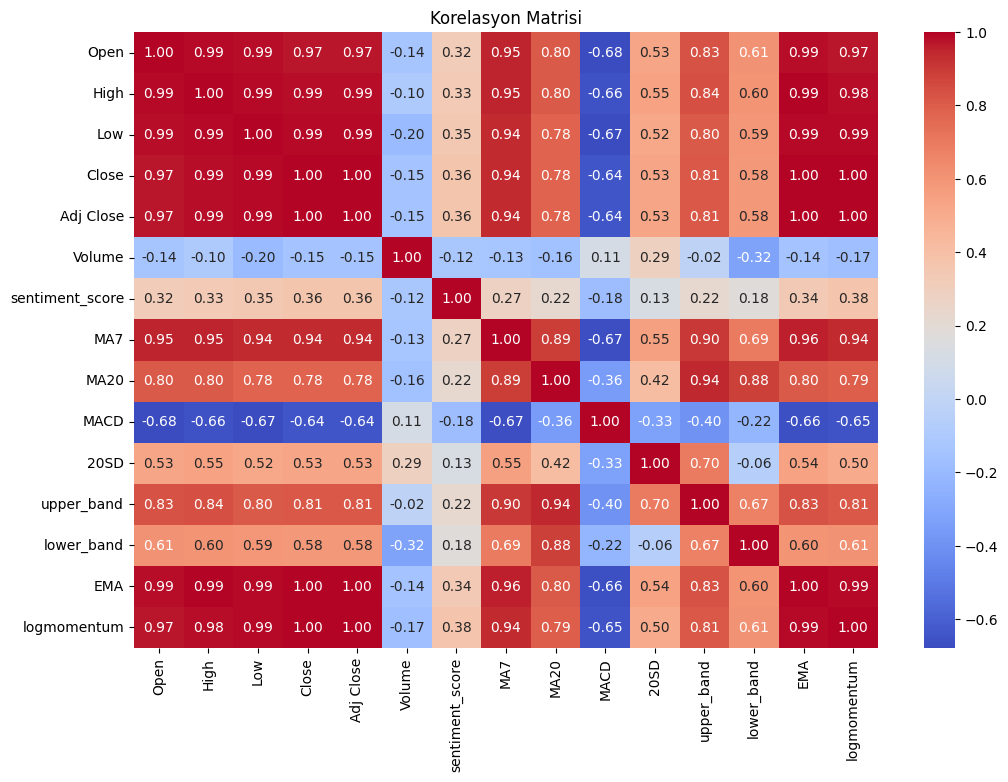

In [ ]:
import matplotlib.pyplot as plt

# Korelasyon matrisi
correlation_matrix = dataset.corr()

# Korelasyon matrisi görselleştirme (Heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Korelasyon Matrisi')
plt.show()

#####  Pairplot (Scatter Matrix)

Scatter matrix ile değişkenler arası dağılım ve ilişki görselleştirilir.
Dağılımlar arasındaki trendleri hızlıca görmek için faydalıdır.

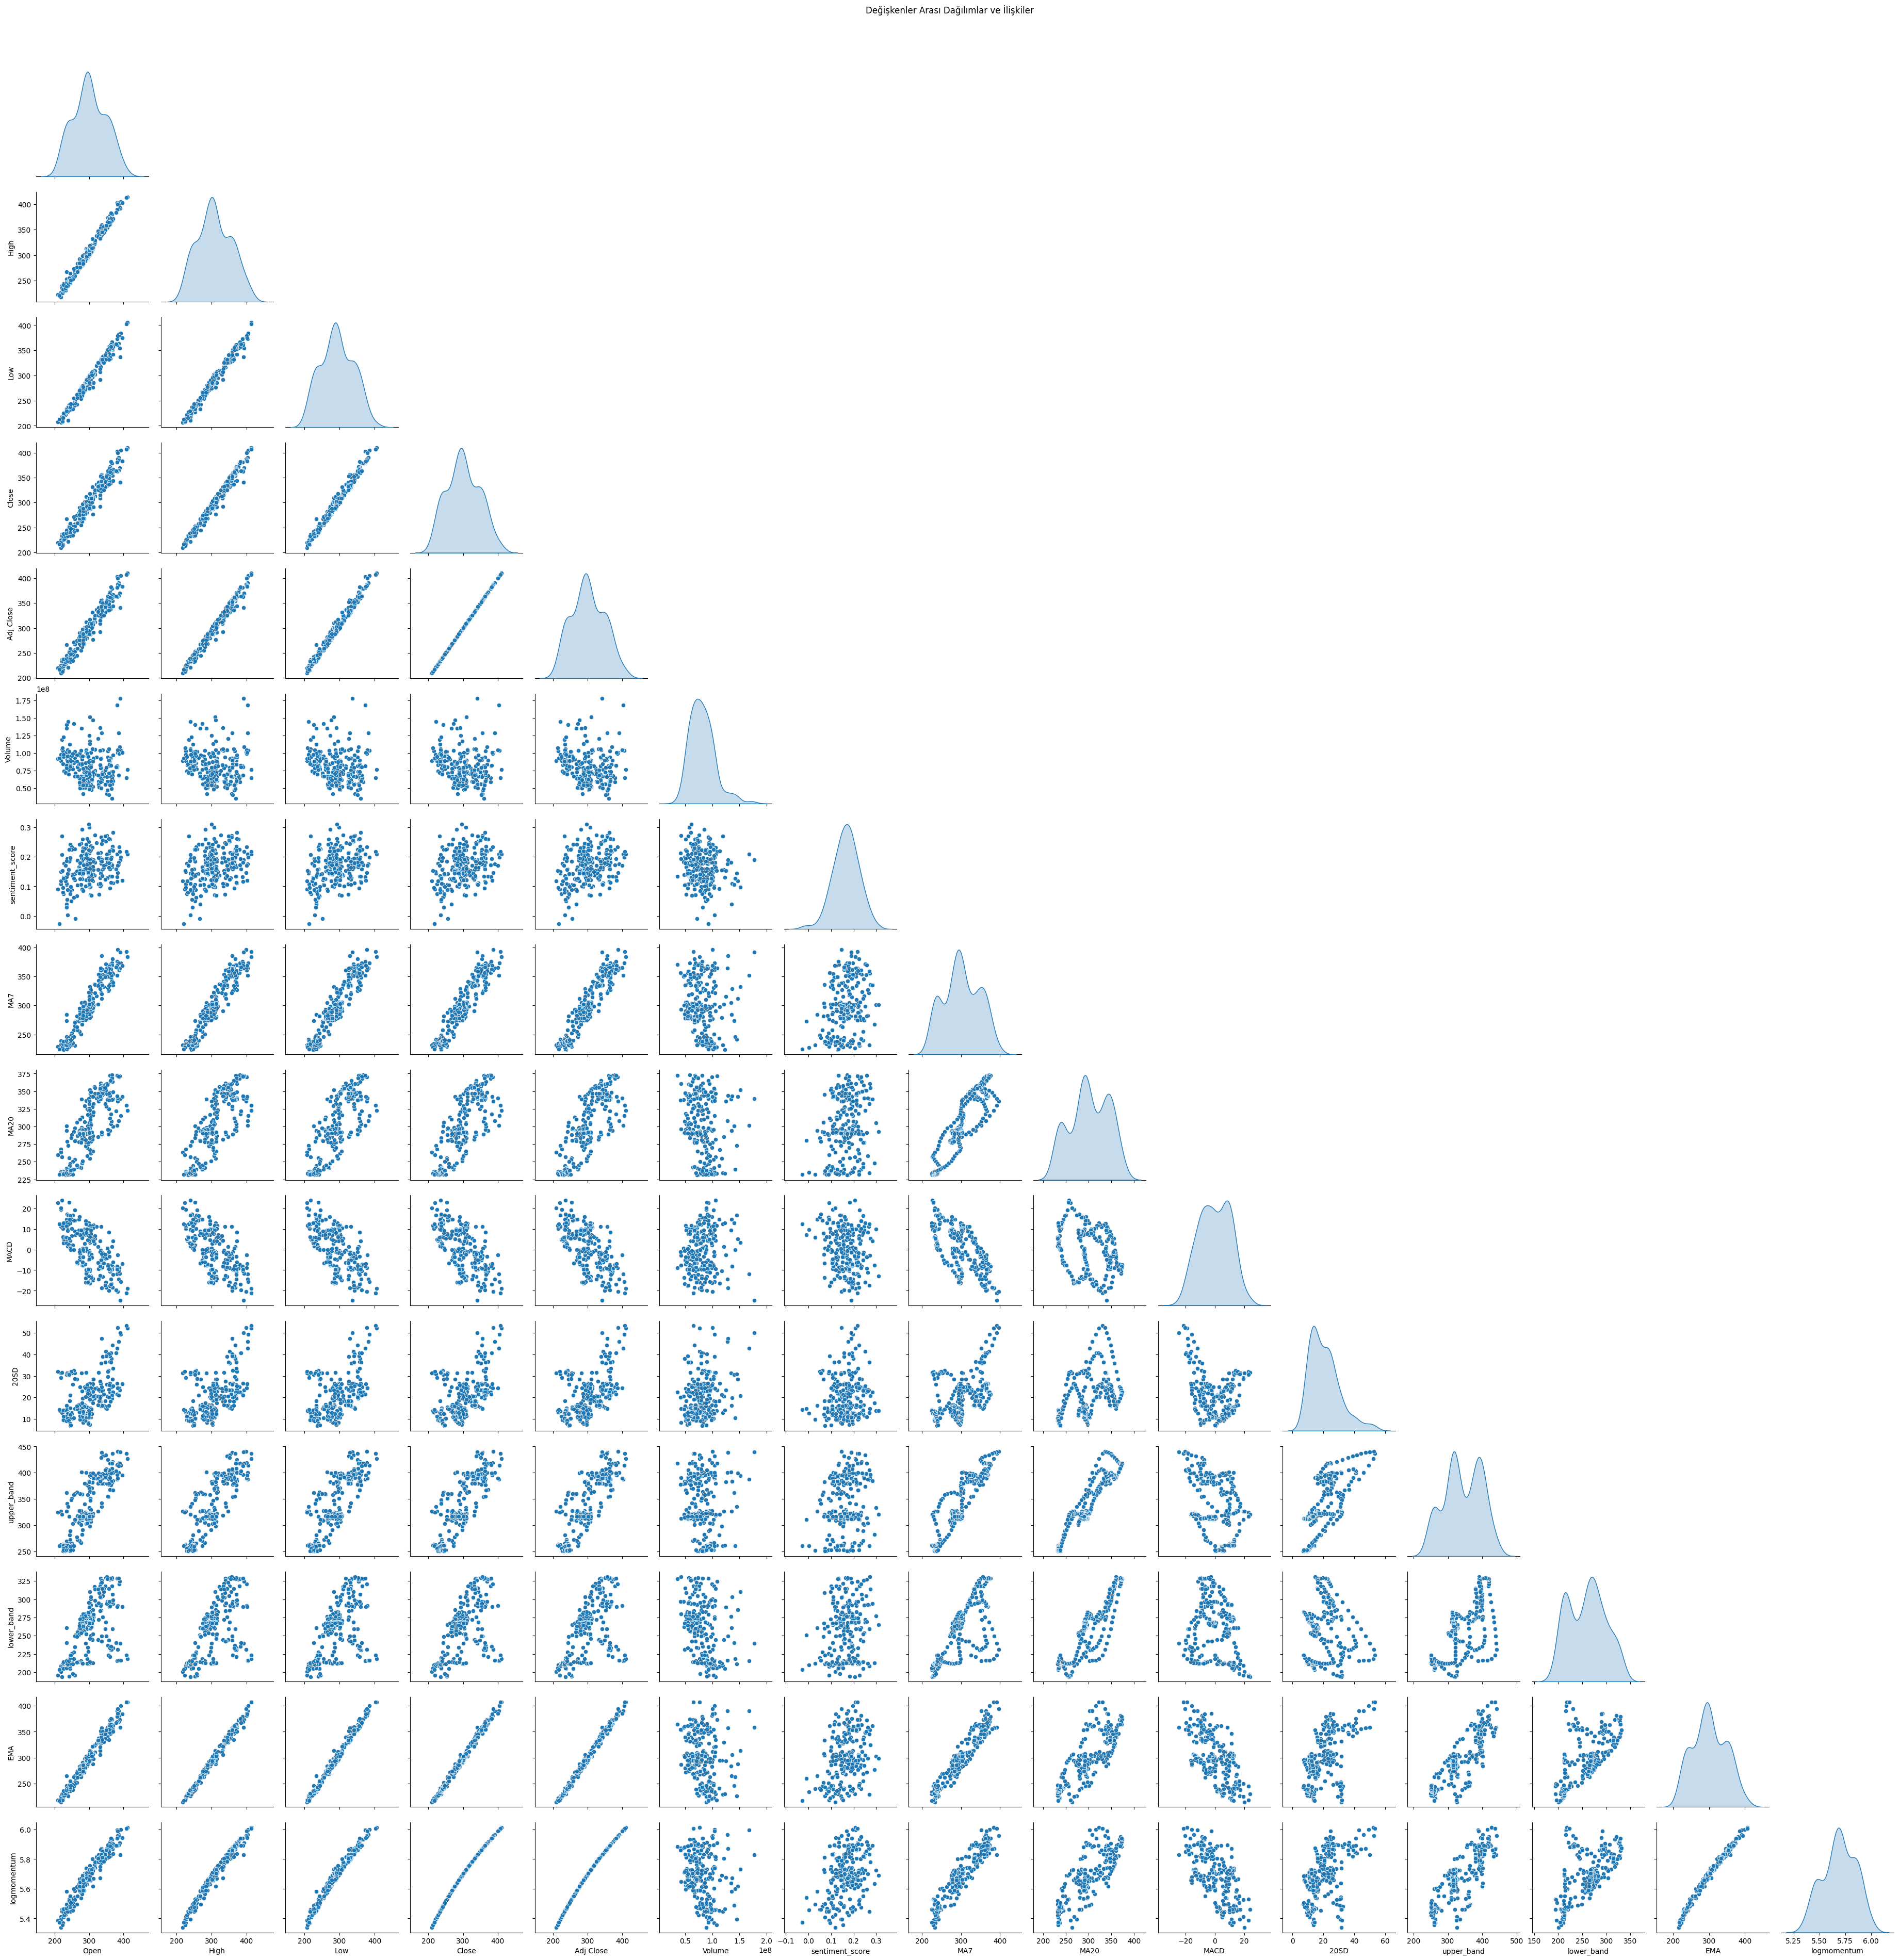

In [ ]:
# Pairplot ile görselleştirme
sns.pairplot(dataset, diag_kind="kde", corner=True)
plt.suptitle('Değişkenler Arası Dağılımlar ve İlişkiler', y=1.02)
plt.show()


##### Zaman Serisi Analizi

Farklı fiyat özelliklerinin (Open, High, Low, Close) zamana bağlı trendlerini karşılaştırıldı.

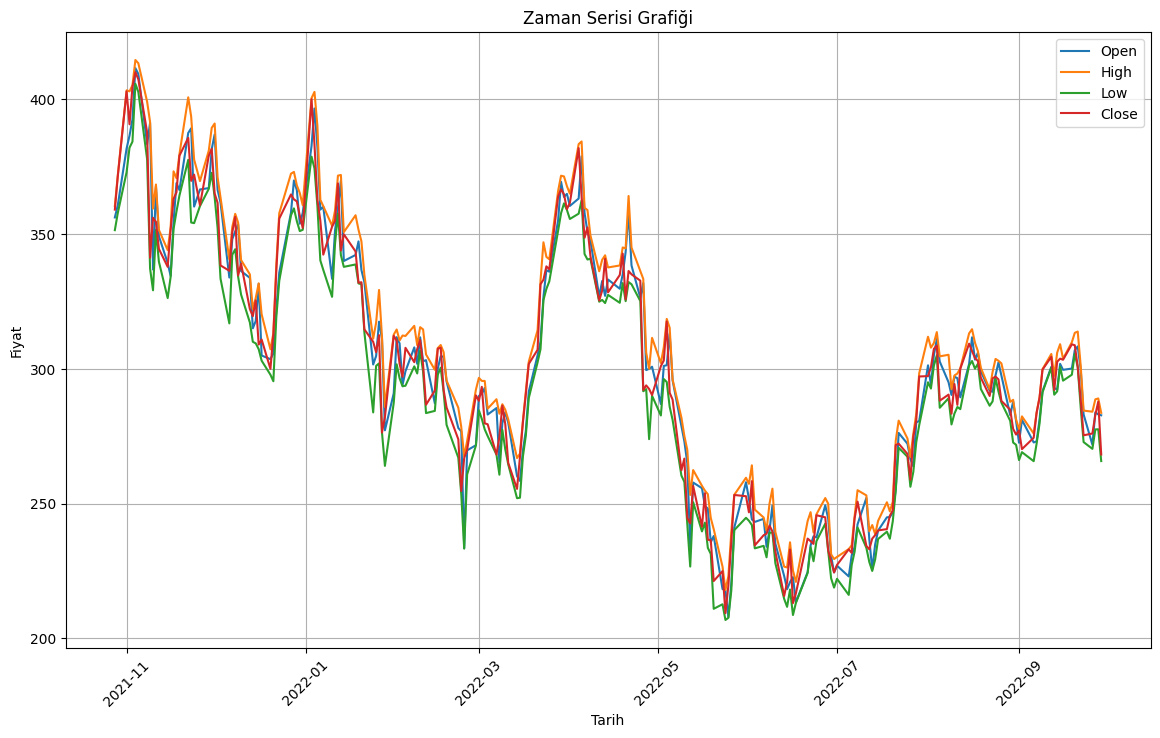

In [ ]:
# Zaman serisi görselleştirme
plt.figure(figsize=(14, 8))
for column in ['Open', 'High', 'Low', 'Close']:
    plt.plot(dataset.index, dataset[column], label=column)
plt.title('Zaman Serisi Grafiği')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


##### Değişkenler Arası Regresyon İlişkileri

Close değişkeni ile diğer bağımsız değişkenler arasındaki ilişkileri incelemek için scatter plot ve doğrusal regresyon çizgileri kullanılmıştır.

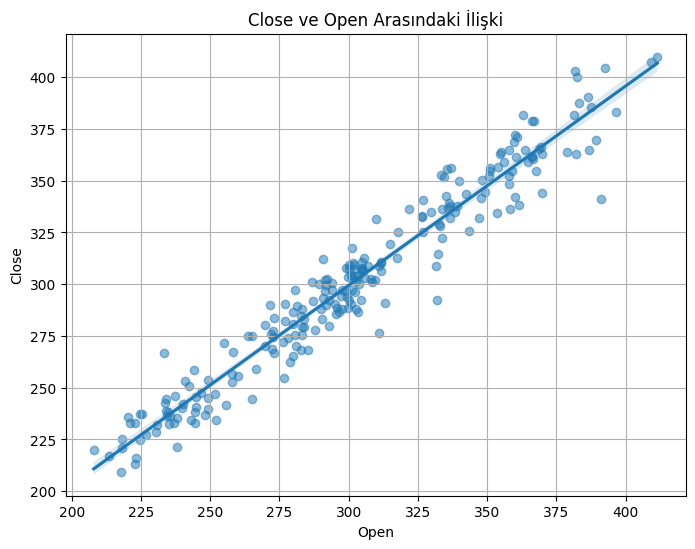

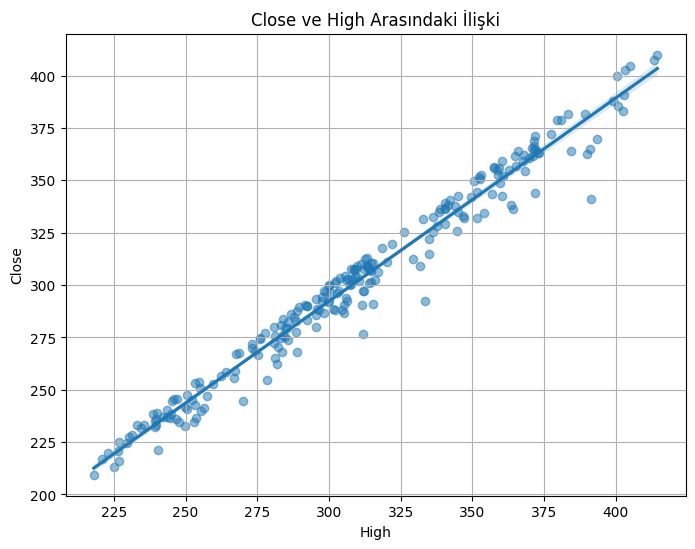

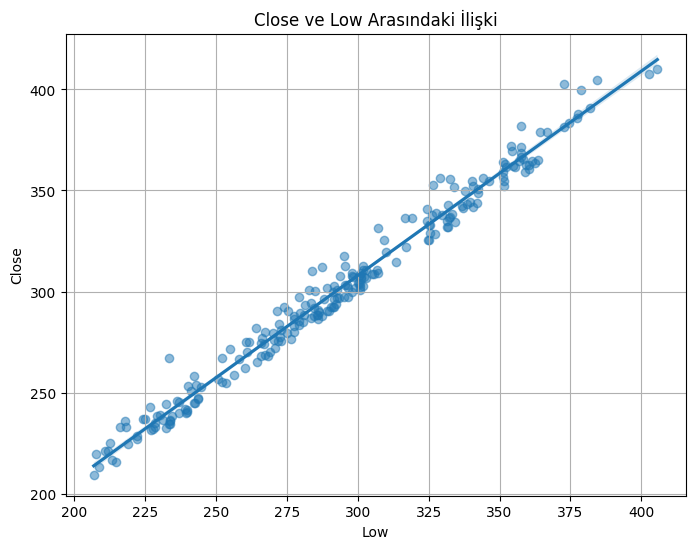

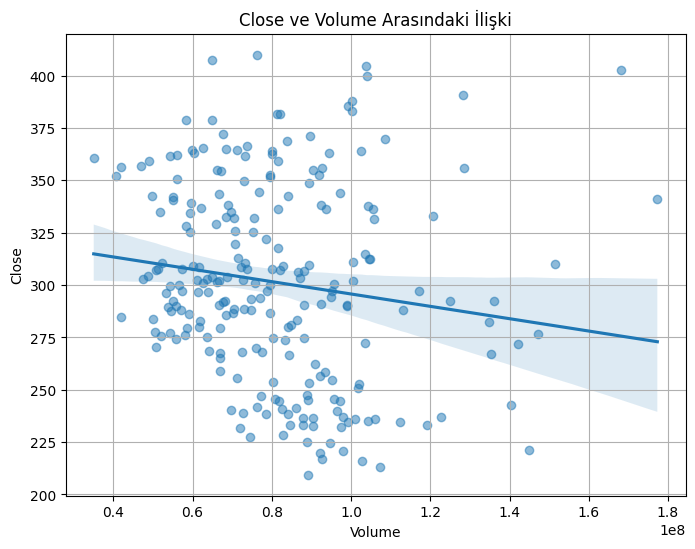

In [ ]:
# Scatter plot between 'Close' and other variables
variables_to_compare = ['Open', 'High', 'Low', 'Volume']

for var in variables_to_compare:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=dataset[var], y=dataset['Close'], scatter_kws={"alpha": 0.5})
    plt.title(f'Close ve {var} Arasındaki İlişki')
    plt.xlabel(var)
    plt.ylabel('Close')
    plt.grid()
    plt.show()


##### Finansal Veri Analizi Teknik Göstergeleri Görselleştirme


Bu kod, finansal veri analizi sırasında teknik göstergeleri (technical indicators) görselleştirmek için yazılmış bir Python fonksiyonudur. Teknik göstergeler, hisse senedi veya diğer finansal araçların fiyat trendlerini anlamaya yardımcı olan hesaplamalardır.

In [ ]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset.index, dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset.index, dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset.index, dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

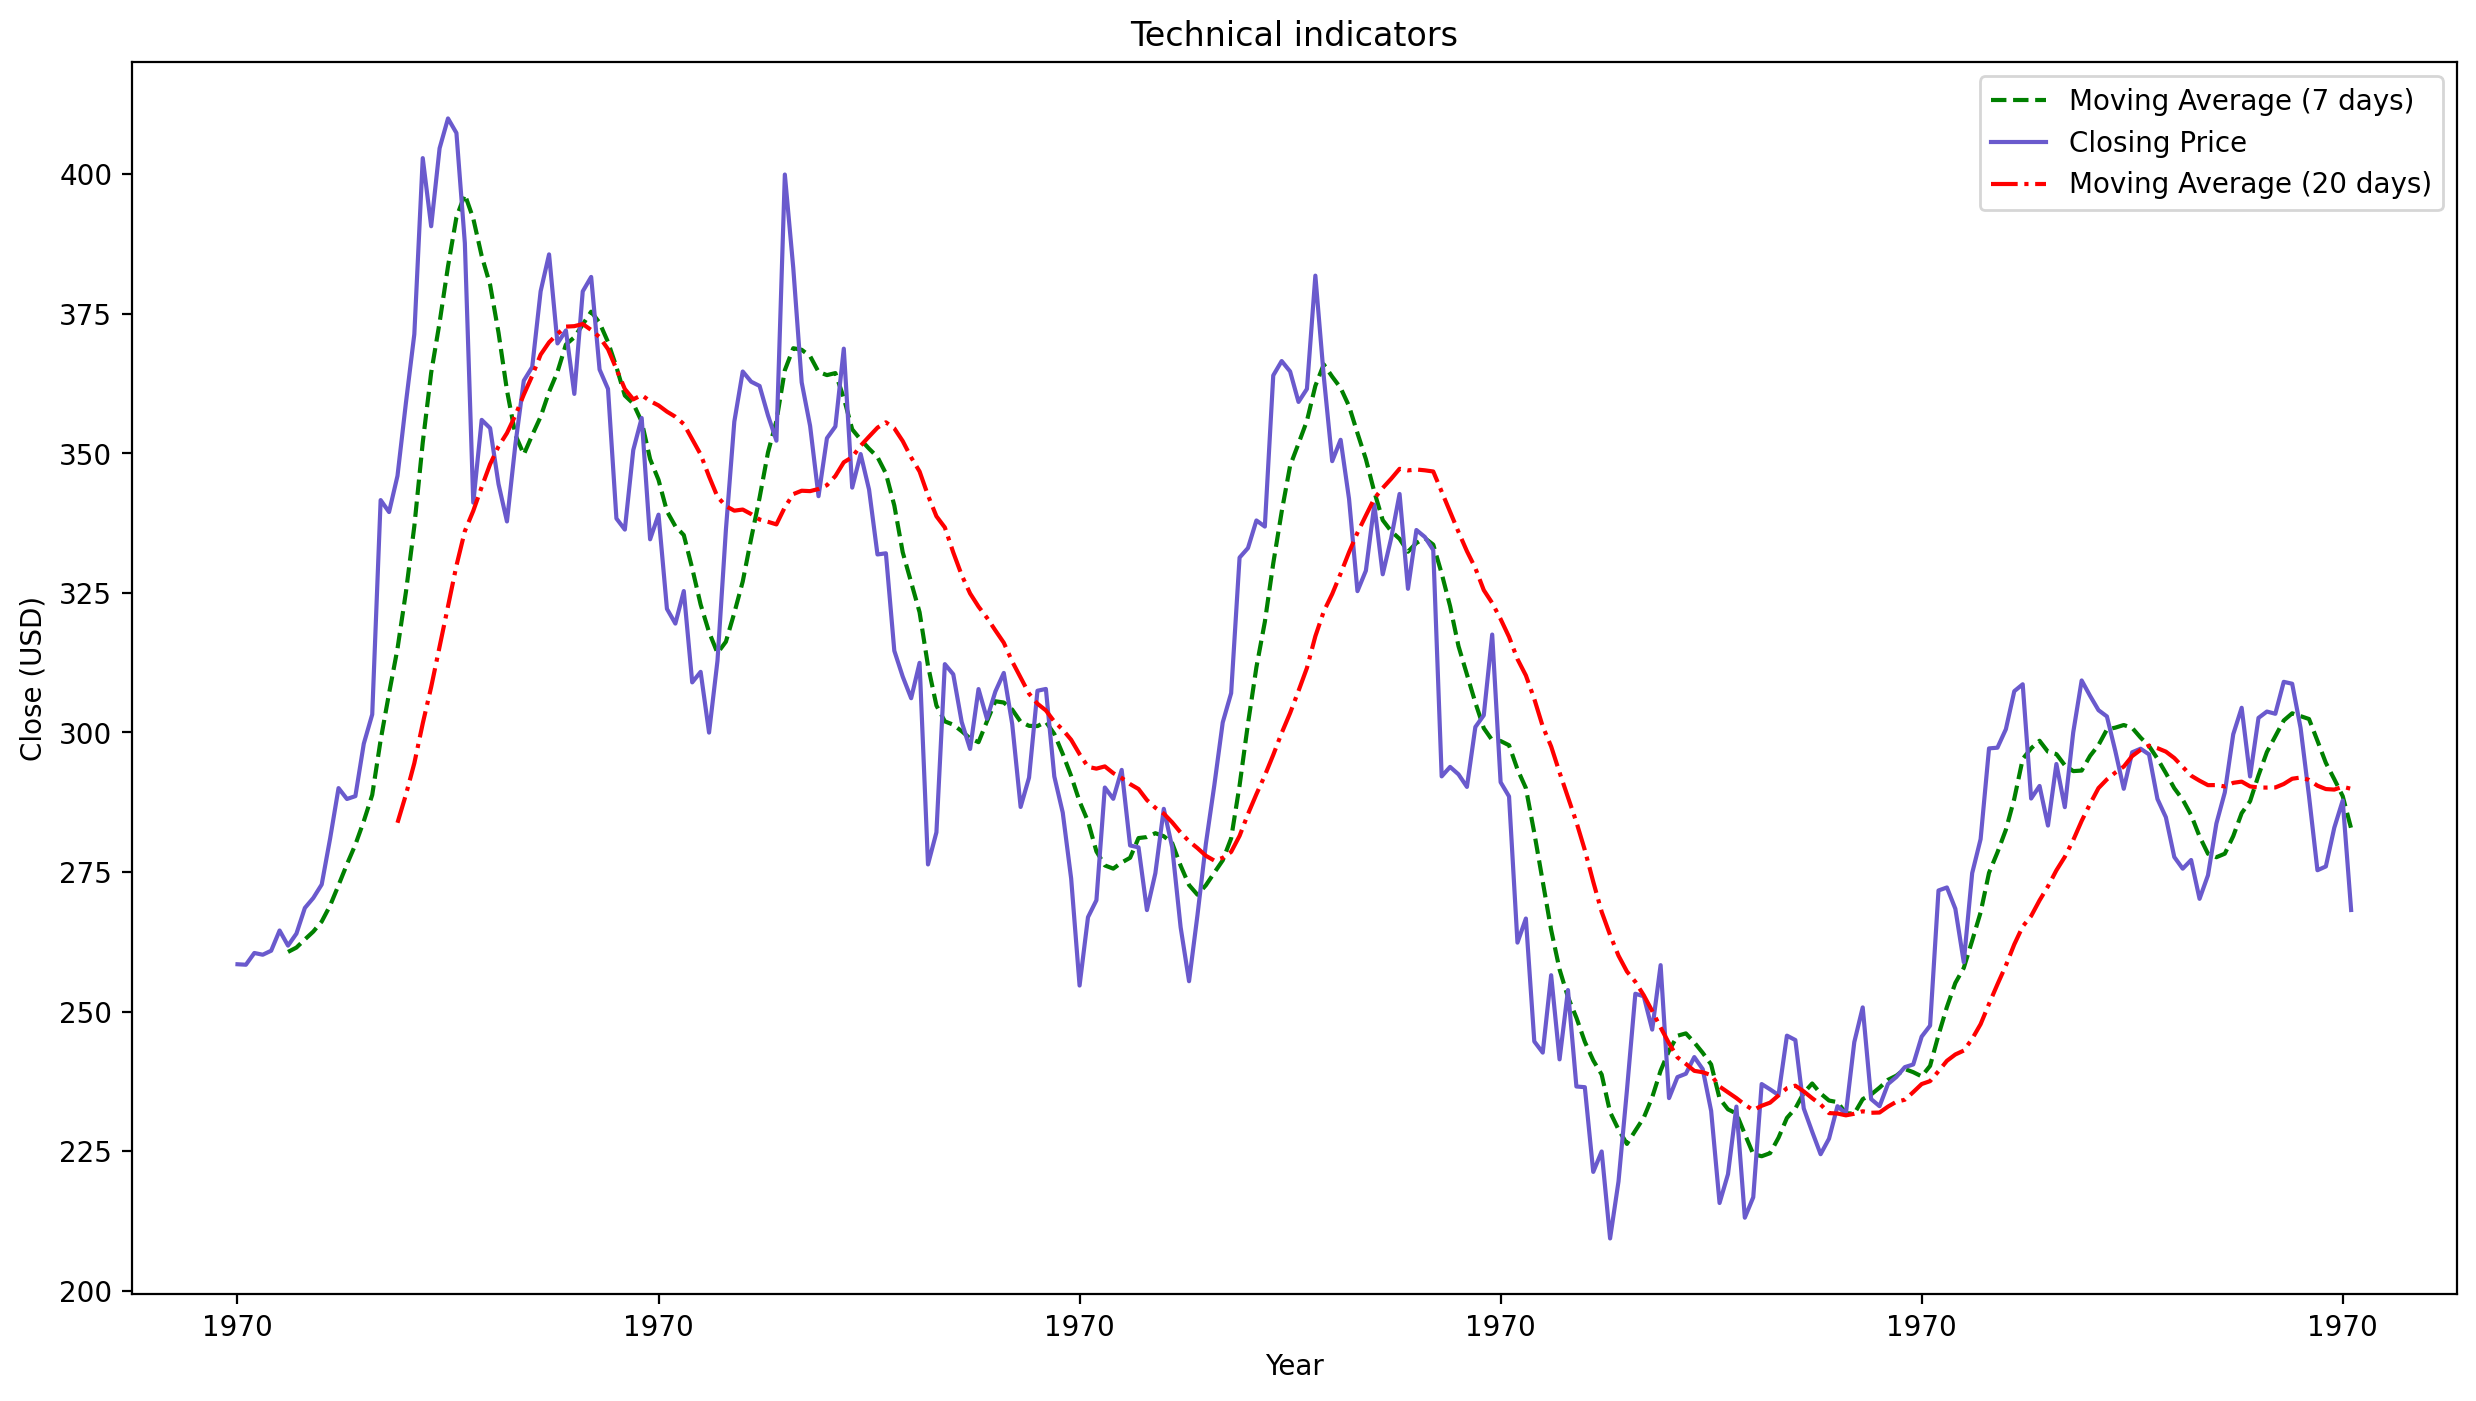

In [ ]:
tech_ind(tech_df)

### Model Oluşturma

#### Batch Fonksiyonu

In [ ]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

#### Train Test Split Fonksiyonu

In [ ]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

#### Predict Fonksiyonu

In [ ]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

#### Fonksiyonların farklı Ölçeklendirmeler için Kullanımı

In [ ]:
# Fonksiyonları uygulama
# RobustScaler ile ölçeklendirilmiş veri
rb_X_batched, rb_y_batched, rb_yc = batch_data(rb_X_scaled, rb_y_scaled, batch_size=5, predict_period=1)
rb_X_train, rb_X_test = split_train_test(rb_X_batched)
rb_y_train, rb_y_test = split_train_test(rb_y_batched)
rb_yc_train, rb_yc_test = split_train_test(rb_yc)
rb_index_train, rb_index_test = predict_index(dataset, rb_X_train, 5, 1)

# StandardScaler ile ölçeklendirilmiş veri
std_X_batched, std_y_batched, std_yc = batch_data(std_X_scaled, std_y_scaled, batch_size=5, predict_period=1)
std_X_train, std_X_test = split_train_test(std_X_batched)
std_y_train, std_y_test = split_train_test(std_y_batched)
std_yc_train, std_yc_test = split_train_test(std_yc)
std_index_train, std_index_test = predict_index(dataset, std_X_train, 5, 1)

# MinMaxScaler ile ölçeklendirilmiş veri
mm_X_batched, mm_y_batched, mm_yc = batch_data(mm_X_scaled, mm_y_scaled, batch_size=5, predict_period=1)
mm_X_train, mm_X_test = split_train_test(mm_X_batched)
mm_y_train, mm_y_test = split_train_test(mm_y_batched)
mm_yc_train, mm_yc_test = split_train_test(mm_yc)
mm_index_train, mm_index_test = predict_index(dataset, mm_X_train, 5, 1)


# Çıktıların kontrolü
print("RobustScaler:")
print("rb_X_train shape:", rb_X_train.shape, "rb_y_train shape:", rb_y_train.shape, "rb_yc_train shape:", rb_yc_train.shape)
print("\nStandardScaler:")
print("std_X_train shape:", std_X_train.shape, "std_y_train shape:", std_y_train.shape, "std_yc_train shape:", std_yc_train.shape)
print("\nMinMaxScaler:")
print("mm_X_train shape:", mm_X_train.shape, "mm_y_train shape:", mm_y_train.shape, "mm_yc_train shape:", mm_yc_train.shape)


RobustScaler:
rb_X_train shape: (207, 5, 14) rb_y_train shape: (207, 1) rb_yc_train shape: (207, 5, 1)

StandardScaler:
std_X_train shape: (207, 5, 14) std_y_train shape: (207, 1) std_yc_train shape: (207, 5, 1)

MinMaxScaler:
mm_X_train shape: (207, 5, 14) mm_y_train shape: (207, 1) mm_yc_train shape: (207, 5, 1)


In [ ]:
input_dim = rb_X_train.shape[1]
feature_size = rb_X_train.shape[2]
output_dim = rb_y_train.shape[1]

print("Input Dimension:", input_dim)
print("Feature Size:", feature_size)
print("Output Dimension:", output_dim)


Input Dimension: 5
Feature Size: 14
Output Dimension: 1


#### LSTM Tabanlı Generator Modeli

Bu fonksiyon, zaman serisi verilerinin öngörüsünü yapmak için bir LSTM (Long Short-Term Memory) tabanlı sinir ağı modelini oluşturur. Model, giriş boyutlarına (input_dim ve feature_size) ve çıkış boyutuna (output_dim) dayalı olarak dinamik bir yapı sunar.

1. Girdi Parametreleri:
 * input_dim: Zaman serisinin sıralı veri uzunluğunu (örneğin, timesteps) temsil eder.
 * output_dim: Modelin tahmin edeceği çıktı boyutunu ifade eder.
 * feature_size: Zaman serisi verilerindeki özellik sayısını ifade eder.
Modelin Yapısı:

2. LSTM Katmanları:
 * İlk 4 LSTM katmanı return_sequences=True olarak ayarlanmıştır, bu da her zaman adımı için çıktıyı bir sonraki katmana aktardığı anlamına gelir.
 * recurrent_dropout=0.3: Modelin overfitting'i önlemesi için tekrar eden birimlerde dropout uygulanır.
 * LSTM birim sayısı kademeli olarak azaltılır (1024 -> 512 -> 256 -> 128 -> 64). Bu, yüksek seviyeli özelliklerin daha karmaşık bir şekilde modellenmesini sağlar ve katmanlar ilerledikçe daha düşük seviyeli özelliklere odaklanır.

3. Dense (Tam Bağlantılı) Katmanlar:
 * Son 4 Dense katmanı, çıkışı daha küçük boyutlara indirerek öngörülen değerleri optimize eder.
 * Son Dense katmanı, output_dim boyutunda bir çıktı üretir.

4. Fonksiyonun Amacı:
 * Bu model, özellikle zaman serisi tahmini (örneğin, hisse senedi fiyatları veya diğer finansal veriler) gibi uygulamalarda kullanılabilir.
 * Model, girdi olarak bir zaman serisi alır ve çıktı olarak öngörülen değerleri verir.

In [ ]:
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([LSTM(units = 1024, return_sequences = True,
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.3),
                               LSTM(units = 512, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 64, recurrent_dropout = 0.3),
                               Dense(32),
                               Dense(16),
                               Dense(8),
                               Dense(units=output_dim)])
    return model

#### Discriminator Modeli

make_discriminator_model fonksiyonu, discriminator adı verilen bir sinir ağı modelini tanımlar. Discriminator, verilen bir girdinin gerçek (real) mi yoksa yapay (fake) mı olduğunu ayırt etmek üzere eğitilir. Bu model genellikle Generative Adversarial Networks (GAN) içinde kullanılır ve generator tarafından üretilen verilerle gerçek veriler arasındaki farkı öğrenmeye çalışır.

1. Conv1D Katmanları:
 * Bir boyutlu evrişim katmanları, zaman serisi verileri veya sekans verilerinde yerel özellikleri yakalamak için kullanılır.
 * LeakyReLU Aktivasyonları: Küçük negatif girişler için bir eğim sağlayarak ReLU'nun dezavantajlarını giderir.

2. Dense Katmanlar:
 * Tam bağlantılı katmanlar, yüksek seviyeli özellikleri öğrenerek çıktıyı bir karar değerine (gerçek veya sahte) indirger.

3. Sigmoid Aktivasyonu:
 * Sonuçta, modelin çıktısı [0, 1] arasında bir olasılık değeri üretir. 1, verinin gerçek olduğunu; 0, sahte olduğunu ifade eder.

In [ ]:
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    #cnn_net.add(Flatten())
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

#### Discriminator Loss Fonksiyonu

discriminator_loss fonksiyonu, discriminator modelinin gerçek ve sahte veriyi ayırt etme başarısını ölçer. Amaç, gerçek veriler için yüksek skor (yakın 1), sahte veriler için düşük skor (yakın 0) sağlamaktır.

In [ ]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### Generator Loss Fonksiyonu

generator_loss fonksiyonu, generator modelinin discriminator'ı kandırma başarısını ölçer. Generator'ın amacı, sahte verileri gerçekmiş gibi gösterecek kadar iyi hale getirmektir.

In [ ]:
def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

Bu üç fonksiyon, Generative Adversarial Networks (GAN) içinde kullanılan temel bileşenlerdir:

Discriminator Modeli: Gerçek ve sahte verileri ayırt etmeyi öğrenir.

Discriminator Loss: Discriminator'ın gerçek ve sahte verileri doğru bir şekilde ayırt etme başarısını ölçer.

Generator Loss: Generator'ın sahte verileri gerçekmiş gibi üretme başarısını ölçer.

Bu yapı, generator ve discriminator'ın karşılıklı rekabet ettiği bir ortam yaratarak, giderek daha gerçekçi veriler üretilmesini sağlar.

#### Tran Step

In [ ]:
@tf.function

def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

#### Train

In [ ]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []


    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())

        #Save model every X checkpoints
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stock_name}/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock_name}/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())

        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)

    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.subplot(2,1,1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

#### Plot Results

In [ ]:
def plot_results(Real_price, Predicted_price, index_train):
    X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/y_scaler.pkl', 'rb'))
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

#### Test

In [ ]:
## Test Code

@tf.function

def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

In [ ]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test, scaler_type, output_dim):
    # Scaler dosyasını yükleme
    scaler_filename = f"{scaler_type}_scaler.pkl"  # Dinamik olarak scaler türünü belirle
    scaler = load(open(scaler_filename, 'rb'))

    # Yalnızca y (target) değerlerini yeniden ölçeklendirme
    rescaled_Real_price = scaler.inverse_transform(
        np.pad(Real_test_price, ((0, 0), (0, scaler.n_features_in_ - Real_test_price.shape[1])), constant_values=0))[:, 0:1]
    rescaled_Predicted_price = scaler.inverse_transform(
        np.pad(Predicted_test_price, ((0, 0), (0, scaler.n_features_in_ - Predicted_test_price.shape[1])), constant_values=0))[:, 0:1]

    # Tahmin sonuçlarını DataFrame olarak oluşturma
    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=index_test[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    # Gerçek sonuçları DataFrame olarak oluşturma
    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=index_test[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    # Ortalama değerler
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # RMSE Hesaplama
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)

    # Tahmin ve gerçek fiyat grafiği
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color='#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data with {scaler_type}", fontsize=20)
    plt.show()


## Modelin Uygulanması

In [ ]:
learning_rate = 5e-4
epochs = 500

g_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
d_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

generator = make_generator_model(rb_X_train.shape[1], output_dim, rb_X_train.shape[2])
discriminator = make_discriminator_model(rb_X_train.shape[1])

### Model Katmanlarının Görselleştirilmesi

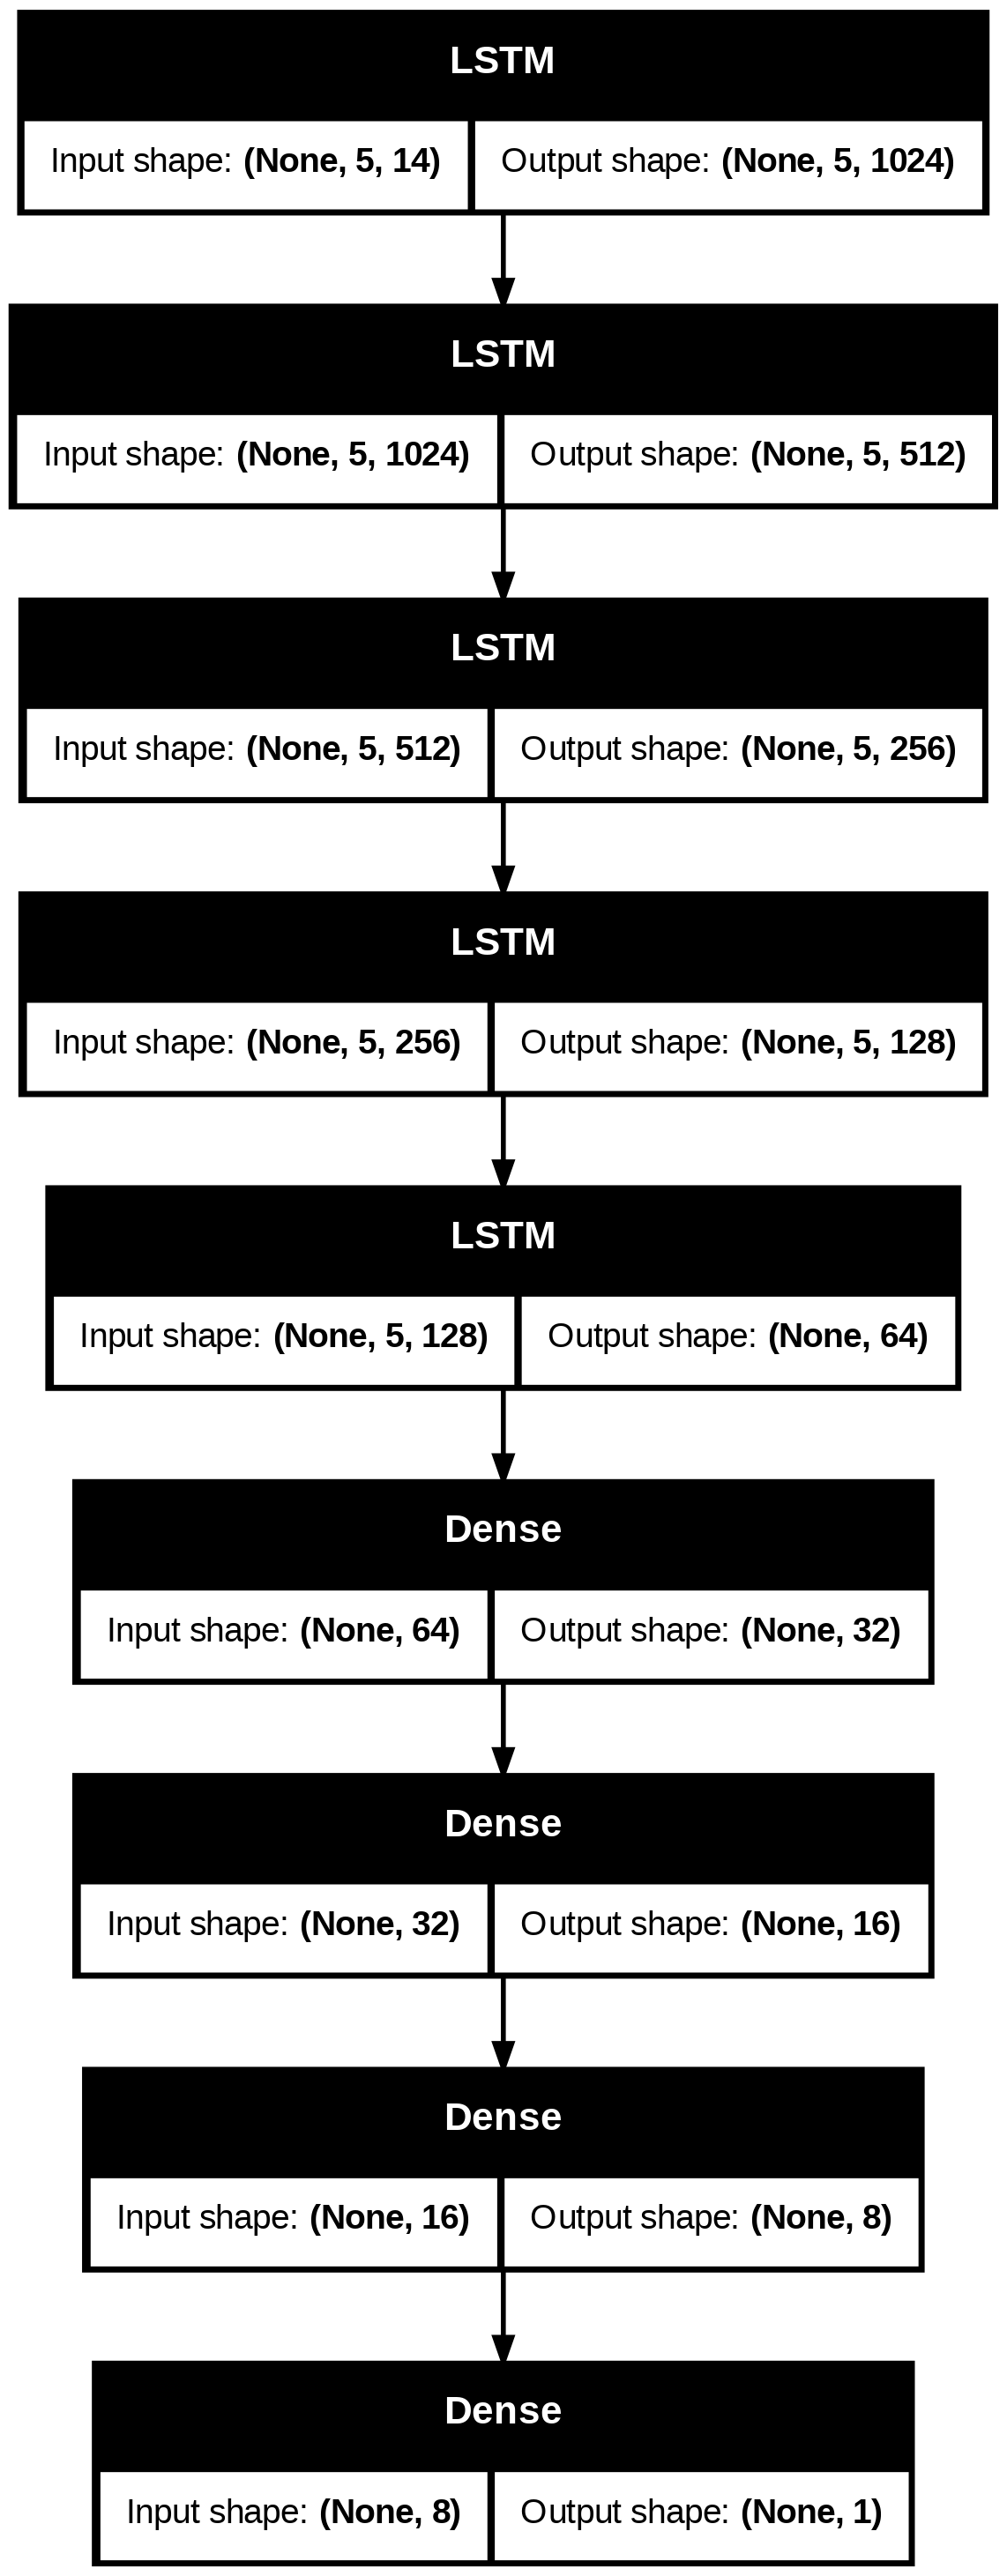

In [ ]:
plot_model(generator, to_file='generator_keras_model.png', show_shapes=True)

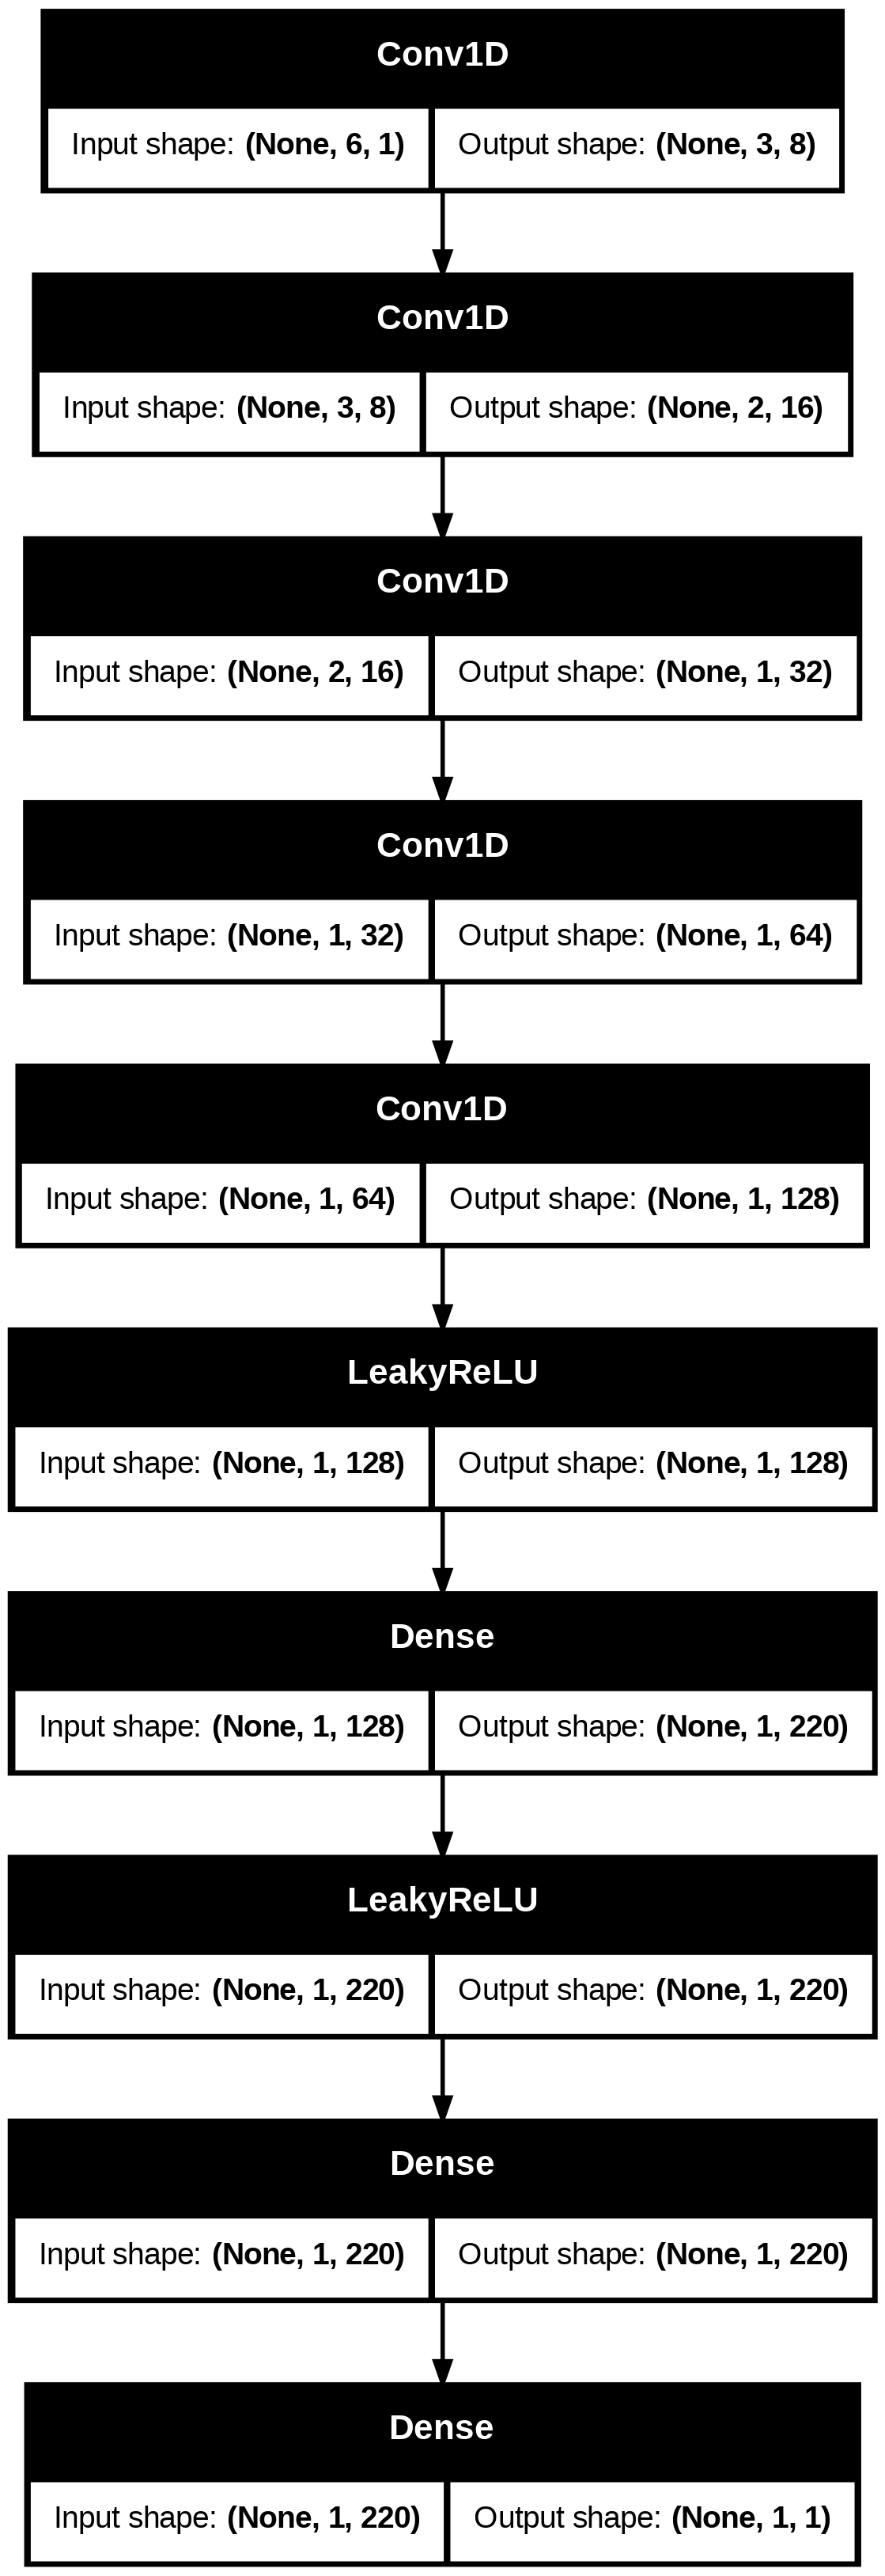

In [ ]:
tf.keras.utils.plot_model(discriminator, to_file='discriminator_keras_model.png', show_shapes=True)

## Modelin Değerlendirilmesi

### Robust Ölçeklendirmesine (RobustScaler) Göre Değerlendirme

 10%|█         | 50/500 [02:28<15:05,  2.01s/it]

epoch 50 discriminator_loss 1.3876324 generator_loss 0.6355673


 20%|██        | 100/500 [04:20<11:41,  1.75s/it]

epoch 100 discriminator_loss 1.3856893 generator_loss 0.70043576


 30%|███       | 150/500 [06:02<11:11,  1.92s/it]

epoch 150 discriminator_loss 1.3894067 generator_loss 0.6906427


 40%|████      | 200/500 [07:42<16:18,  3.26s/it]

epoch 200 discriminator_loss 1.386682 generator_loss 0.6912557


 50%|█████     | 250/500 [09:18<07:15,  1.74s/it]

epoch 250 discriminator_loss 1.3872776 generator_loss 0.69559413


 60%|██████    | 300/500 [10:47<05:48,  1.74s/it]

epoch 300 discriminator_loss 1.3883431 generator_loss 0.68471175


 70%|███████   | 350/500 [12:19<05:09,  2.06s/it]

epoch 350 discriminator_loss 1.3862702 generator_loss 0.68991363


 80%|████████  | 400/500 [13:53<03:33,  2.13s/it]

epoch 400 discriminator_loss 1.3882172 generator_loss 0.69916373


 90%|█████████ | 450/500 [15:26<01:30,  1.81s/it]

epoch 450 discriminator_loss 1.3885245 generator_loss 0.694927


100%|██████████| 500/500 [16:59<00:00,  2.04s/it]


epoch 500 discriminator_loss 1.385485 generator_loss 0.68456984


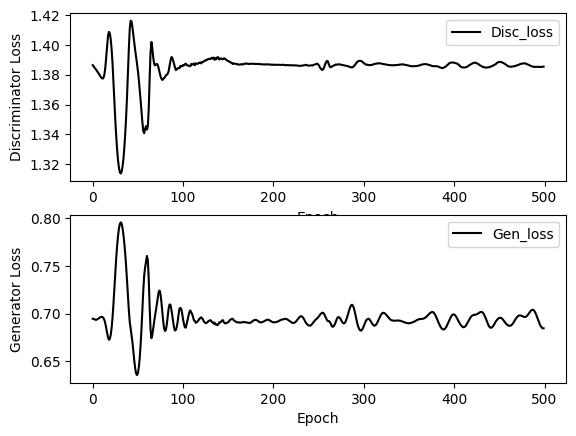

In [ ]:
rb_predicted_price, rb_real_price, rb_RMSPE = train(rb_X_train, rb_y_train, rb_yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)



In [ ]:
test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.h5')

Test RMSE:  9.08070063370755


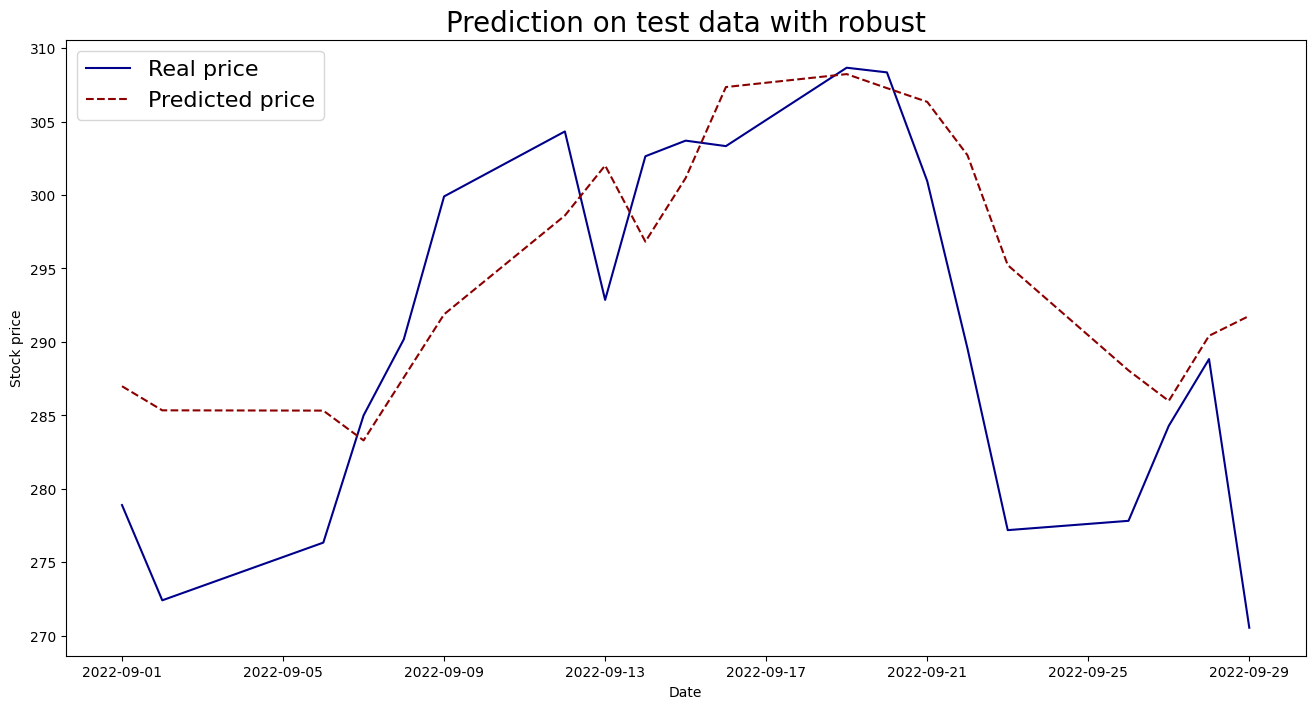

In [ ]:
predicted_test_data = eval_op(test_generator, rb_X_test)
plot_test_data(rb_y_test, predicted_test_data, rb_index_test,  "robust", output_dim)

### Z-Score Standardizasyonuna (Standardization) Göre Değerlendirme

 10%|█         | 50/500 [02:04<15:44,  2.10s/it]

epoch 50 discriminator_loss 1.3857179 generator_loss 0.6918859


 20%|██        | 100/500 [03:38<13:45,  2.06s/it]

epoch 100 discriminator_loss 1.3865831 generator_loss 0.7068614


 30%|███       | 150/500 [05:13<11:26,  1.96s/it]

epoch 150 discriminator_loss 1.3858514 generator_loss 0.69256294


 40%|████      | 200/500 [06:46<09:12,  1.84s/it]

epoch 200 discriminator_loss 1.3866582 generator_loss 0.69435495


 50%|█████     | 250/500 [08:22<08:31,  2.05s/it]

epoch 250 discriminator_loss 1.3860267 generator_loss 0.69100744


 60%|██████    | 300/500 [09:57<06:27,  1.94s/it]

epoch 300 discriminator_loss 1.3838922 generator_loss 0.70983523


 70%|███████   | 350/500 [11:30<04:29,  1.80s/it]

epoch 350 discriminator_loss 1.3861612 generator_loss 0.6979423


 80%|████████  | 400/500 [13:05<03:24,  2.04s/it]

epoch 400 discriminator_loss 1.3889611 generator_loss 0.68817323


 90%|█████████ | 450/500 [14:39<01:36,  1.92s/it]

epoch 450 discriminator_loss 1.3856065 generator_loss 0.6879547


100%|██████████| 500/500 [16:12<00:00,  1.95s/it]


epoch 500 discriminator_loss 1.3848023 generator_loss 0.6945148


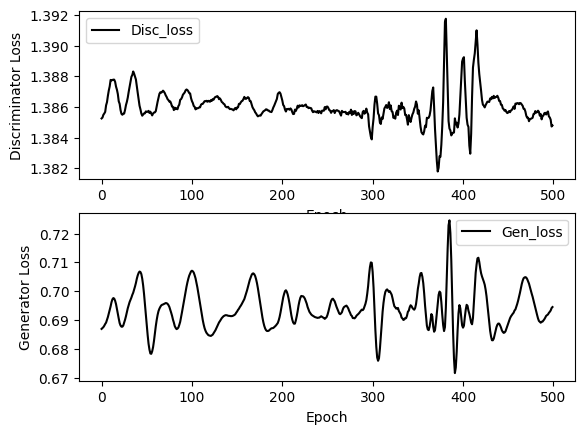

In [ ]:
std_predicted_price, std_real_price, std_RMSPE = train(std_X_train, std_y_train, std_yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)


Test RMSE:  10.221370098385885


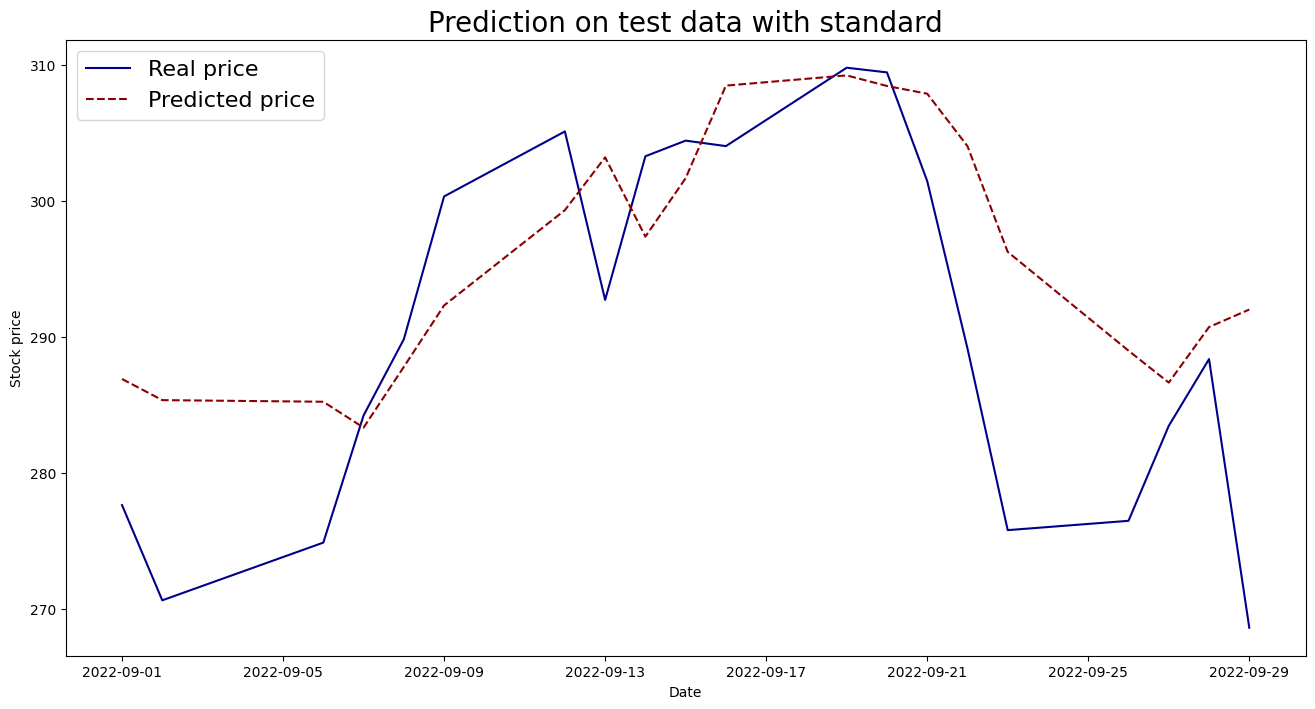

In [ ]:
predicted_test_data = eval_op(test_generator, std_X_test)
plot_test_data(std_y_test, predicted_test_data, std_index_test,  "standard", output_dim)

### Min-Max Ölçeklendirmesine (Normalization) Göre Değerlendirme


 10%|█         | 50/500 [01:40<14:35,  1.95s/it]

epoch 50 discriminator_loss 1.387378 generator_loss 0.69086003


 20%|██        | 100/500 [03:10<12:19,  1.85s/it]

epoch 100 discriminator_loss 1.3865654 generator_loss 0.69474787


 30%|███       | 150/500 [04:44<13:13,  2.27s/it]

epoch 150 discriminator_loss 1.3866633 generator_loss 0.69904786


 40%|████      | 200/500 [06:30<09:31,  1.90s/it]

epoch 200 discriminator_loss 1.3864422 generator_loss 0.6891868


 50%|█████     | 250/500 [08:05<08:33,  2.05s/it]

epoch 250 discriminator_loss 1.3862866 generator_loss 0.685957


 60%|██████    | 300/500 [09:39<06:45,  2.03s/it]

epoch 300 discriminator_loss 1.3864043 generator_loss 0.7071592


 70%|███████   | 350/500 [11:12<04:20,  1.74s/it]

epoch 350 discriminator_loss 1.3864553 generator_loss 0.6867426


 80%|████████  | 400/500 [12:43<02:52,  1.73s/it]

epoch 400 discriminator_loss 1.3863776 generator_loss 0.68115795


 90%|█████████ | 450/500 [14:18<01:45,  2.11s/it]

epoch 450 discriminator_loss 1.3864237 generator_loss 0.68864644


100%|██████████| 500/500 [15:51<00:00,  1.90s/it]


epoch 500 discriminator_loss 1.3862001 generator_loss 0.69546473


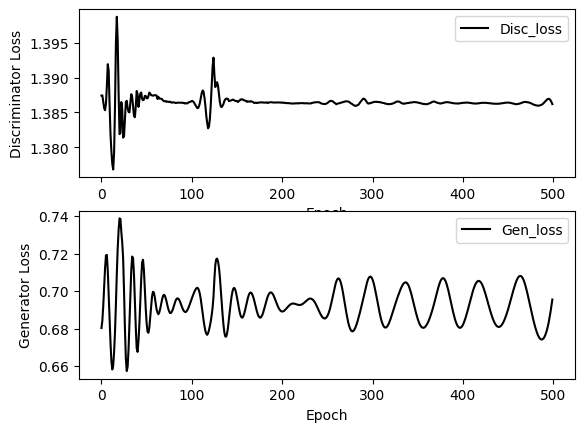

In [ ]:
mm_predicted_price, mm_real_price, mm_RMSPE = train(mm_X_train, mm_y_train, mm_yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)


Test RMSE:  10.773735361513392


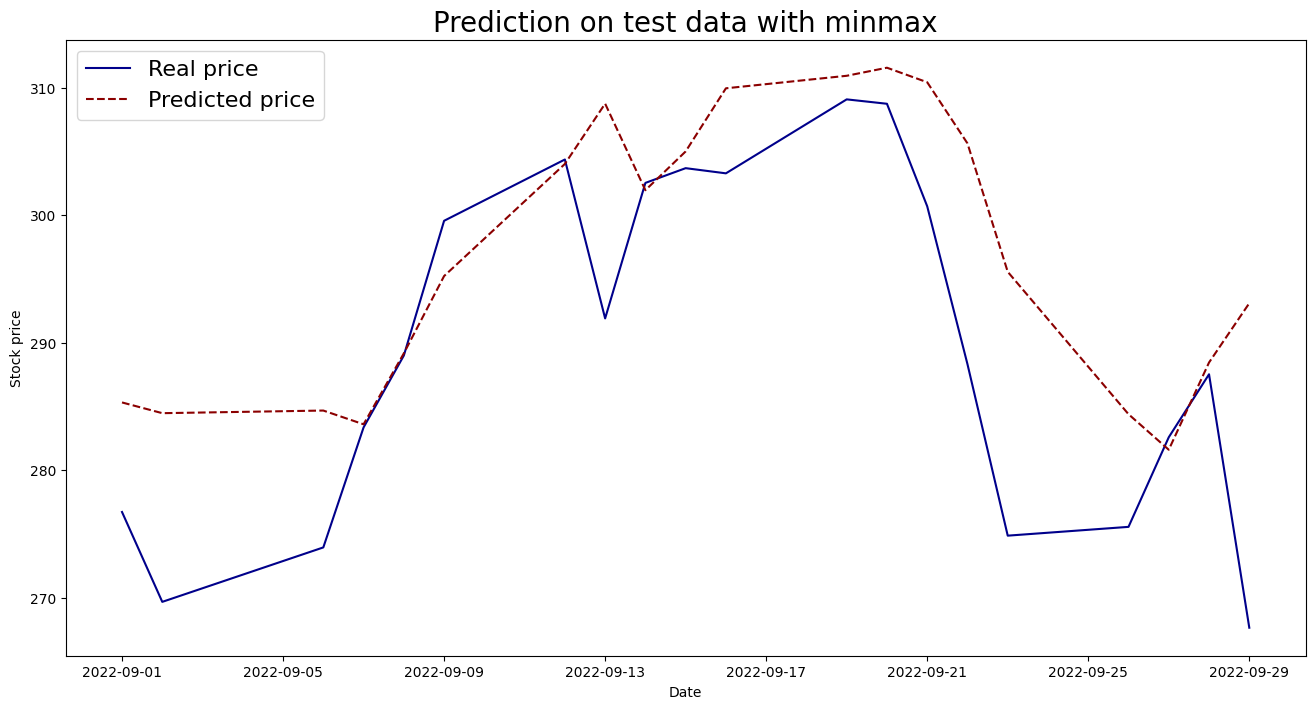

In [ ]:
predicted_test_data = eval_op(test_generator, mm_X_test)
plot_test_data(mm_y_test, predicted_test_data, mm_index_test,  "minmax", output_dim)

## Sonuçların Yorumlanması

*   Robust Ölçeklenmesine Göre RMSE: 9.08070063370755
*   Z- Score Standartına Göre RMSE: 10.221370098385885
*   Min-Max Ölçeklendirmesine Göre RMSE: 10.773735361513392

En küçük RMSE değeri Robut olduğu için bu daha başarılı bulunmuştur.





